In [1]:
import pandas as pd
import numpy as np
import json
import warnings
import spacy
warnings.filterwarnings("ignore")
import random

import nltk
from nltk.stem import WordNetLemmatizer

import re

from spacy.tokens import DocBin

from tqdm import tqdm

In [2]:
train_data = pd.read_csv("C:\\Users\\preet\\Desktop\\CAPstone\\train.csv")
features = pd.read_csv("C:\\Users\\preet\\Desktop\\CAPstone\\features.csv")
patient_notes = pd.read_csv("C:\\Users\\preet\\Desktop\\CAPstone\\patient_notes.csv")

### CASE - 9

In [3]:
case_9_features = features[features["case_num"] == 9]
case_9_features

,feature_num,case_num,feature_text
126,900,9,No-relief-with-Motrin-OR-no-relief-with-tylenol
127,901,9,20-year
128,902,9,1-day-duration-OR-2-days-duration
129,903,9,Myalgias
130,904,9,Global-headache-OR-diffuse-headache
131,905,9,Neck-pain
132,906,9,Vomiting
133,907,9,No-rash
134,908,9,Nausea
135,909,9,viral-symptoms-OR-rhinorrhea-OR-scratchy-throat


In [4]:
case_9_pn = patient_notes[patient_notes["case_num"] ==  9]
case_9_pn

,pn_num,case_num,pn_history
36995,90000,9,HPI: Ms. Madden is a 20 year old previously he...
36996,90001,9,Ms. Madden is a 40 yo f presenting with progre...
36997,90002,9,"20 yo F with 2 days of 8/10 dull, achy headach..."
36998,90003,9,"20 yo f c/o headache started yesterday , sudde..."
36999,90004,9,Ms. Madden is a 20 yo female who presents with...
...,...,...,...
42141,95330,9,Ms. Madden is a 20 yo female presenting w/ the...
42142,95331,9,A 20 YO F CAME COMPLAIN A DULL 8/10 HEADACHE T...
42143,95332,9,Ms. Madden is a 20yo female who presents with ...
42144,95333,9,Stephanie madden is a 20 year old woman compla...


In [5]:
case_9_train = train_data[train_data["case_num"] == 9]
case_9_train = case_9_train[case_9_train.annotation != '[]']
case_9_train.head()

,id,case_num,pn_num,feature_num,annotation,location
12600,90127_900,9,90127,900,"['tylenol no relief', 'ibuprofen no relief']","['251 258;284 293', '264 273;284 293']"
12601,90127_901,9,90127,901,['20 year old'],['34 45']
12602,90127_902,9,90127,902,['yesterday'],['102 111']
12606,90127_906,9,90127,906,['vomiting'],['347 355']
12608,90127_908,9,90127,908,['nausea'],['321 327']


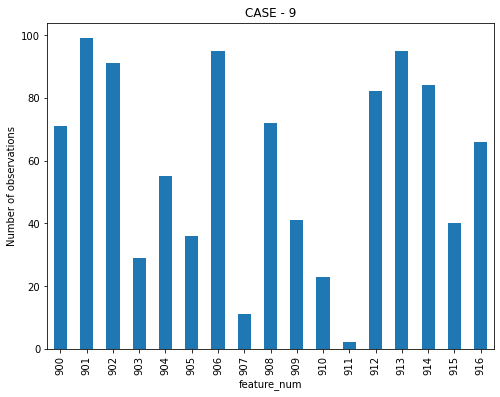

In [6]:
import matplotlib.pyplot as plt
plt.figure(figsize=[8,6])
case_9_train.groupby("feature_num").size().plot.bar()
plt.title("CASE - 9")
plt.ylabel("Number of observations")
plt.show()

### Over Sampling for CASE - 9

In [7]:
pn_dict = {}
for idx, row in case_9_pn.iterrows():
    pn_dict[row['pn_num']] = row['pn_history']

In [8]:
new_annotation = []
for case_id in case_9_features['case_num'].unique():
    
    all_pn_id = set(case_9_pn[case_9_pn['case_num']==case_id]['pn_num'].tolist())
    
    for feature_id in case_9_features[case_9_features['case_num']==case_id]['feature_num'].unique():
        # get all the pn_num that have already been annotated
        annotated_pn = set(case_9_train[case_9_train['feature_num']==feature_id]['pn_num'].tolist())
        # get all the pn_num that have NOT been annotated
        pn_to_annotate = all_pn_id-annotated_pn
        
        # get all current annotations
        # we will use them to find more annotations
        annotations = case_9_train[case_9_train['feature_num']==feature_id]['annotation'].tolist()
        annotation_texts = set()
        for a in annotations:
            anns = eval(a)
            for at in anns:
                annotation_texts.add(at)
                
        # annotate       
        for pn_id in pn_to_annotate:
            new_annotation_pn, new_location_pn = [], []
            pn_text = pn_dict[pn_id]
            for at in annotation_texts:
                start = pn_text.find(at)
                if start>=0:
                    new_annotation_pn.append(at)
                    new_location_pn.append(f'{start} {start+len(at)}')
            if len(new_annotation_pn)>0:
                new_annotation.append((
                    f'{pn_id:04d}_{feature_id:03d}',
                    case_id,
                    pn_id,
                    feature_id,
                    new_annotation_pn,
                    new_location_pn
                ))
     #   break
    break
    # break to get sample results quickly

In [9]:
len(new_annotation)

40873

In [10]:
df=pd.DataFrame(new_annotation)
df.head()

,0,1,2,3,4,5
0,90046_900,9,90046,900,[tylenol have not helped],[324 347]
1,90082_900,9,90082,900,[ibuprofen have not helped],[161 186]
2,90118_900,9,90118,900,[ibuprofen have not helped],[435 460]
3,90122_900,9,90122,900,[tylenol with no relief],[497 519]
4,90124_900,9,90124,900,[No relief with tylenol],[360 382]


In [11]:
df.columns=['id','case_num','pn_num','feature_num','annotation','location']
df.head()

,id,case_num,pn_num,feature_num,annotation,location
0,90046_900,9,90046,900,[tylenol have not helped],[324 347]
1,90082_900,9,90082,900,[ibuprofen have not helped],[161 186]
2,90118_900,9,90118,900,[ibuprofen have not helped],[435 460]
3,90122_900,9,90122,900,[tylenol with no relief],[497 519]
4,90124_900,9,90124,900,[No relief with tylenol],[360 382]


In [12]:
df["location"] = df["location"].apply(str)
df["annotation"] = df["annotation"].apply(str)

df["annotation"] = df.annotation.str.replace('[','')
df["annotation"] = df.annotation.str.replace(']','')
df["location"] = df.location.str.replace('[','')
df["location"] = df.location.str.replace(']','')

df.head()

,id,case_num,pn_num,feature_num,annotation,location
0,90046_900,9,90046,900,'tylenol have not helped','324 347'
1,90082_900,9,90082,900,'ibuprofen have not helped','161 186'
2,90118_900,9,90118,900,'ibuprofen have not helped','435 460'
3,90122_900,9,90122,900,'tylenol with no relief','497 519'
4,90124_900,9,90124,900,'No relief with tylenol','360 382'


In [13]:
df = df[(df["feature_num"] == 905)|(df["feature_num"] == 907)][['pn_num','annotation',"location","feature_num"]]
df.shape

(1548, 4)

In [14]:
df = (df.set_index(['pn_num',"feature_num"]) 
   .apply(lambda col: col.str.split(',').explode())
   .reset_index()
   .reindex(df.columns, axis=1))
df

,pn_num,annotation,location,feature_num
0,90000,'neck pain','580 589',905
1,90001,'neck stiffness','390 404',905
2,90007,'neck stiffness','188 202',905
3,90011,'neck pain','381 390',905
4,90022,'neck stiffness','473 487',905
...,...,...,...,...
1604,95143,'denies rash','307 318',907
1605,95162,'denies rash','313 324',907
1606,95226,'No rashes','442 451',907
1607,95275,'Denies rash','448 459',907


In [15]:
df["start_location"] = df["location"].apply(lambda x: x.split()[0][1:])
df["end_location"] = df["location"].apply(lambda x: x.split()[-1][:-1])
df

,pn_num,annotation,location,feature_num,start_location,end_location
0,90000,'neck pain','580 589',905,580,589
1,90001,'neck stiffness','390 404',905,390,404
2,90007,'neck stiffness','188 202',905,188,202
3,90011,'neck pain','381 390',905,381,390
4,90022,'neck stiffness','473 487',905,473,487
...,...,...,...,...,...,...
1604,95143,'denies rash','307 318',907,307,318
1605,95162,'denies rash','313 324',907,313,324
1606,95226,'No rashes','442 451',907,442,451
1607,95275,'Denies rash','448 459',907,448,459


In [16]:
df_905 = df[df["feature_num"] == 905].sample(n = 160, random_state = 100)
df_905.shape

(160, 6)

In [17]:
df_907 = df[df["feature_num"] == 907].sample(n = 150, random_state = 100)
df_907.shape

(150, 6)

### Case - 9 Train data

In [18]:
case_9_train = case_9_train[['pn_num','annotation',"location","feature_num"]]

In [19]:
case_9_train["annotation"] = case_9_train.annotation.str.replace('[','')
case_9_train["annotation"] = case_9_train.annotation.str.replace(']','')
case_9_train["location"] = case_9_train.location.str.replace('[','')
case_9_train["location"] = case_9_train.location.str.replace(']','')

case_9_train

,pn_num,annotation,location,feature_num
12600,90127,"'tylenol no relief', 'ibuprofen no relief'","'251 258;284 293', '264 273;284 293'",900
12601,90127,'20 year old','34 45',901
12602,90127,'yesterday','102 111',902
12606,90127,'vomiting','347 355',906
12608,90127,'nausea','321 327',908
...,...,...,...,...
14291,95333,'Nausea','354 360',908
14293,95333,'lives with roomate','576 594',910
14297,95333,'photobia','274 282',914
14298,95333,'no sick contacts','421 437',915


In [20]:
case_9_train.loc[case_9_train["annotation"] == "'ibuprofen not better', 'tylenol , not better'","annotation"] = "'ibuprofen not better', 'tylenol   not better'"
case_9_train.loc[case_9_train["annotation"] == "'HA front, back, and on sides of head'","annotation"] = "'HA front  back  and on sides of head'"
case_9_train.loc[case_9_train["annotation"] == "'headache , generalised'","annotation"] = "'headache   generalised'"

In [21]:
case_9_train = (case_9_train.set_index(['pn_num',"feature_num"]) 
   .apply(lambda col: col.str.split(',').explode())
   .reset_index()
   .reindex(case_9_train.columns, axis=1))
case_9_train

,pn_num,annotation,location,feature_num
0,90127,'tylenol no relief','251 258;284 293',900
1,90127,'ibuprofen no relief','264 273;284 293',900
2,90127,'20 year old','34 45',901
3,90127,'yesterday','102 111',902
4,90127,'vomiting','347 355',906
...,...,...,...,...
1208,95333,'Nausea','354 360',908
1209,95333,'lives with roomate','576 594',910
1210,95333,'photobia','274 282',914
1211,95333,'no sick contacts','421 437',915


In [22]:
case_9_train["start_location"] = case_9_train["location"].apply(lambda x: x.split()[0][1:])
case_9_train["end_location"] = case_9_train["location"].apply(lambda x: x.split()[-1][:-1])
case_9_train

,pn_num,annotation,location,feature_num,start_location,end_location
0,90127,'tylenol no relief','251 258;284 293',900,251,293
1,90127,'ibuprofen no relief','264 273;284 293',900,264,293
2,90127,'20 year old','34 45',901,34,45
3,90127,'yesterday','102 111',902,102,111
4,90127,'vomiting','347 355',906,347,355
...,...,...,...,...,...,...
1208,95333,'Nausea','354 360',908,354,360
1209,95333,'lives with roomate','576 594',910,576,594
1210,95333,'photobia','274 282',914,274,282
1211,95333,'no sick contacts','421 437',915,421,437


In [23]:
case_9 = pd.concat([case_9_train, df_905, df_907])
case_9.shape

(1523, 6)

In [24]:
case_9 = case_9.merge(patient_notes, on='pn_num', how='left')
case_9

,pn_num,annotation,location,feature_num,start_location,end_location,case_num,pn_history
0,90127,'tylenol no relief','251 258;284 293',900,251,293,9,CC: Headache\r\nHPI: Ms Maddon is a 20 year ol...
1,90127,'ibuprofen no relief','264 273;284 293',900,264,293,9,CC: Headache\r\nHPI: Ms Maddon is a 20 year ol...
2,90127,'20 year old','34 45',901,34,45,9,CC: Headache\r\nHPI: Ms Maddon is a 20 year ol...
3,90127,'yesterday','102 111',902,102,111,9,CC: Headache\r\nHPI: Ms Maddon is a 20 year ol...
4,90127,'vomiting','347 355',906,347,355,9,CC: Headache\r\nHPI: Ms Maddon is a 20 year ol...
...,...,...,...,...,...,...,...,...
1518,93959,'denies rash','384 395',907,384,395,9,"20 yo F c/o headache that started 2 days ago, ..."
1519,92690,'denies rash','493 504',907,493,504,9,Stephanie Madden is a 20 yo F complaining of H...
1520,92872,'no rash','483 490',907,483,490,9,Patient is a 20 yo F presenting with c/o of he...
1521,94339,'no rash','688 695',907,688,695,9,The patient is a 20 yo female presenting with ...


In [25]:
case_9["New_annotation"] = case_9.apply(lambda x: x.pn_history[int(x.start_location):int(x.end_location)],axis=1)
case_9.head()

,pn_num,annotation,location,feature_num,start_location,end_location,case_num,pn_history,New_annotation
0,90127,'tylenol no relief','251 258;284 293',900,251,293,9,CC: Headache\r\nHPI: Ms Maddon is a 20 year ol...,"tylenol, and ibuprofen and found no relief"
1,90127,'ibuprofen no relief','264 273;284 293',900,264,293,9,CC: Headache\r\nHPI: Ms Maddon is a 20 year ol...,ibuprofen and found no relief
2,90127,'20 year old','34 45',901,34,45,9,CC: Headache\r\nHPI: Ms Maddon is a 20 year ol...,20 year old
3,90127,'yesterday','102 111',902,102,111,9,CC: Headache\r\nHPI: Ms Maddon is a 20 year ol...,yesterday
4,90127,'vomiting','347 355',906,347,355,9,CC: Headache\r\nHPI: Ms Maddon is a 20 year ol...,vomiting


In [26]:
case_9["New_annotation"] = case_9["New_annotation"].apply(lambda x: re.sub(r'''[/"+,()\r\n]''',' ',x))
case_9["New_annotation"] = case_9["New_annotation"].apply(lambda x: re.sub(r'''[']''','',x))
case_9["New_annotation"] = case_9["New_annotation"].apply(lambda x: x.strip())
case_9

,pn_num,annotation,location,feature_num,start_location,end_location,case_num,pn_history,New_annotation
0,90127,'tylenol no relief','251 258;284 293',900,251,293,9,CC: Headache\r\nHPI: Ms Maddon is a 20 year ol...,tylenol and ibuprofen and found no relief
1,90127,'ibuprofen no relief','264 273;284 293',900,264,293,9,CC: Headache\r\nHPI: Ms Maddon is a 20 year ol...,ibuprofen and found no relief
2,90127,'20 year old','34 45',901,34,45,9,CC: Headache\r\nHPI: Ms Maddon is a 20 year ol...,20 year old
3,90127,'yesterday','102 111',902,102,111,9,CC: Headache\r\nHPI: Ms Maddon is a 20 year ol...,yesterday
4,90127,'vomiting','347 355',906,347,355,9,CC: Headache\r\nHPI: Ms Maddon is a 20 year ol...,vomiting
...,...,...,...,...,...,...,...,...,...
1518,93959,'denies rash','384 395',907,384,395,9,"20 yo F c/o headache that started 2 days ago, ...",denies rash
1519,92690,'denies rash','493 504',907,493,504,9,Stephanie Madden is a 20 yo F complaining of H...,denies rash
1520,92872,'no rash','483 490',907,483,490,9,Patient is a 20 yo F presenting with c/o of he...,no rash
1521,94339,'no rash','688 695',907,688,695,9,The patient is a 20 yo female presenting with ...,no rash


In [27]:
case_9["New_pn_history"] = case_9["pn_history"].apply(lambda x: re.sub(r'''[/",+()\r\n]''',' ',x))
case_9["New_pn_history"] = case_9["New_pn_history"].apply(lambda x: re.sub(r'''[']''','',x))
case_9

,pn_num,annotation,location,feature_num,start_location,end_location,case_num,pn_history,New_annotation,New_pn_history
0,90127,'tylenol no relief','251 258;284 293',900,251,293,9,CC: Headache\r\nHPI: Ms Maddon is a 20 year ol...,tylenol and ibuprofen and found no relief,CC: Headache HPI: Ms Maddon is a 20 year old ...
1,90127,'ibuprofen no relief','264 273;284 293',900,264,293,9,CC: Headache\r\nHPI: Ms Maddon is a 20 year ol...,ibuprofen and found no relief,CC: Headache HPI: Ms Maddon is a 20 year old ...
2,90127,'20 year old','34 45',901,34,45,9,CC: Headache\r\nHPI: Ms Maddon is a 20 year ol...,20 year old,CC: Headache HPI: Ms Maddon is a 20 year old ...
3,90127,'yesterday','102 111',902,102,111,9,CC: Headache\r\nHPI: Ms Maddon is a 20 year ol...,yesterday,CC: Headache HPI: Ms Maddon is a 20 year old ...
4,90127,'vomiting','347 355',906,347,355,9,CC: Headache\r\nHPI: Ms Maddon is a 20 year ol...,vomiting,CC: Headache HPI: Ms Maddon is a 20 year old ...
...,...,...,...,...,...,...,...,...,...,...
1518,93959,'denies rash','384 395',907,384,395,9,"20 yo F c/o headache that started 2 days ago, ...",denies rash,20 yo F c o headache that started 2 days ago ...
1519,92690,'denies rash','493 504',907,493,504,9,Stephanie Madden is a 20 yo F complaining of H...,denies rash,Stephanie Madden is a 20 yo F complaining of H...
1520,92872,'no rash','483 490',907,483,490,9,Patient is a 20 yo F presenting with c/o of he...,no rash,Patient is a 20 yo F presenting with c o of he...
1521,94339,'no rash','688 695',907,688,695,9,The patient is a 20 yo female presenting with ...,no rash,The patient is a 20 yo female presenting with ...


In [28]:
def word_lemm(sentence):
    word_list = nltk.word_tokenize(sentence)
    
    lemmaztier = WordNetLemmatizer()
    lemmatized_output = ' '.join([lemmaztier.lemmatize(w) for w in word_list])
    return(lemmatized_output)

In [29]:
case_9["New_annotation"] = case_9["New_annotation"].apply(word_lemm)
case_9["New_pn_history"] = case_9["New_pn_history"].apply(word_lemm)
case_9.head()

,pn_num,annotation,location,feature_num,start_location,end_location,case_num,pn_history,New_annotation,New_pn_history
0,90127,'tylenol no relief','251 258;284 293',900,251,293,9,CC: Headache\r\nHPI: Ms Maddon is a 20 year ol...,tylenol and ibuprofen and found no relief,CC : Headache HPI : Ms Maddon is a 20 year old...
1,90127,'ibuprofen no relief','264 273;284 293',900,264,293,9,CC: Headache\r\nHPI: Ms Maddon is a 20 year ol...,ibuprofen and found no relief,CC : Headache HPI : Ms Maddon is a 20 year old...
2,90127,'20 year old','34 45',901,34,45,9,CC: Headache\r\nHPI: Ms Maddon is a 20 year ol...,20 year old,CC : Headache HPI : Ms Maddon is a 20 year old...
3,90127,'yesterday','102 111',902,102,111,9,CC: Headache\r\nHPI: Ms Maddon is a 20 year ol...,yesterday,CC : Headache HPI : Ms Maddon is a 20 year old...
4,90127,'vomiting','347 355',906,347,355,9,CC: Headache\r\nHPI: Ms Maddon is a 20 year ol...,vomiting,CC : Headache HPI : Ms Maddon is a 20 year old...


In [30]:
case_9["new_location"] = case_9.apply(lambda x :re.search(r'\b' + x.New_annotation + r'\b', x.New_pn_history),axis =1)
case_9

,pn_num,annotation,location,feature_num,start_location,end_location,case_num,pn_history,New_annotation,New_pn_history,new_location
0,90127,'tylenol no relief','251 258;284 293',900,251,293,9,CC: Headache\r\nHPI: Ms Maddon is a 20 year ol...,tylenol and ibuprofen and found no relief,CC : Headache HPI : Ms Maddon is a 20 year old...,"<re.Match object; span=(248, 289), match='tyle..."
1,90127,'ibuprofen no relief','264 273;284 293',900,264,293,9,CC: Headache\r\nHPI: Ms Maddon is a 20 year ol...,ibuprofen and found no relief,CC : Headache HPI : Ms Maddon is a 20 year old...,"<re.Match object; span=(260, 289), match='ibup..."
2,90127,'20 year old','34 45',901,34,45,9,CC: Headache\r\nHPI: Ms Maddon is a 20 year ol...,20 year old,CC : Headache HPI : Ms Maddon is a 20 year old...,"<re.Match object; span=(35, 46), match='20 yea..."
3,90127,'yesterday','102 111',902,102,111,9,CC: Headache\r\nHPI: Ms Maddon is a 20 year ol...,yesterday,CC : Headache HPI : Ms Maddon is a 20 year old...,"<re.Match object; span=(102, 111), match='yest..."
4,90127,'vomiting','347 355',906,347,355,9,CC: Headache\r\nHPI: Ms Maddon is a 20 year ol...,vomiting,CC : Headache HPI : Ms Maddon is a 20 year old...,"<re.Match object; span=(341, 349), match='vomi..."
...,...,...,...,...,...,...,...,...,...,...,...
1518,93959,'denies rash','384 395',907,384,395,9,"20 yo F c/o headache that started 2 days ago, ...",denies rash,20 yo F c o headache that started 2 day ago de...,"<re.Match object; span=(370, 381), match='deni..."
1519,92690,'denies rash','493 504',907,493,504,9,Stephanie Madden is a 20 yo F complaining of H...,denies rash,Stephanie Madden is a 20 yo F complaining of H...,"<re.Match object; span=(487, 498), match='deni..."
1520,92872,'no rash','483 490',907,483,490,9,Patient is a 20 yo F presenting with c/o of he...,no rash,Patient is a 20 yo F presenting with c o of he...,"<re.Match object; span=(485, 492), match='no r..."
1521,94339,'no rash','688 695',907,688,695,9,The patient is a 20 yo female presenting with ...,no rash,The patient is a 20 yo female presenting with ...,"<re.Match object; span=(670, 677), match='no r..."


In [31]:
drop_index = []
for  index,row in case_9.iterrows():
    if row["new_location"] == None:
        drop_index.append(index)
        
print(drop_index),len(drop_index)

[304, 308, 309, 312, 463, 591, 656, 665, 763, 764, 906, 909, 915, 930, 1025, 1083, 1169, 1170, 1418]


(None, 19)

In [32]:
case_9 = case_9.drop(drop_index,axis = 0)
case_9

,pn_num,annotation,location,feature_num,start_location,end_location,case_num,pn_history,New_annotation,New_pn_history,new_location
0,90127,'tylenol no relief','251 258;284 293',900,251,293,9,CC: Headache\r\nHPI: Ms Maddon is a 20 year ol...,tylenol and ibuprofen and found no relief,CC : Headache HPI : Ms Maddon is a 20 year old...,"<re.Match object; span=(248, 289), match='tyle..."
1,90127,'ibuprofen no relief','264 273;284 293',900,264,293,9,CC: Headache\r\nHPI: Ms Maddon is a 20 year ol...,ibuprofen and found no relief,CC : Headache HPI : Ms Maddon is a 20 year old...,"<re.Match object; span=(260, 289), match='ibup..."
2,90127,'20 year old','34 45',901,34,45,9,CC: Headache\r\nHPI: Ms Maddon is a 20 year ol...,20 year old,CC : Headache HPI : Ms Maddon is a 20 year old...,"<re.Match object; span=(35, 46), match='20 yea..."
3,90127,'yesterday','102 111',902,102,111,9,CC: Headache\r\nHPI: Ms Maddon is a 20 year ol...,yesterday,CC : Headache HPI : Ms Maddon is a 20 year old...,"<re.Match object; span=(102, 111), match='yest..."
4,90127,'vomiting','347 355',906,347,355,9,CC: Headache\r\nHPI: Ms Maddon is a 20 year ol...,vomiting,CC : Headache HPI : Ms Maddon is a 20 year old...,"<re.Match object; span=(341, 349), match='vomi..."
...,...,...,...,...,...,...,...,...,...,...,...
1518,93959,'denies rash','384 395',907,384,395,9,"20 yo F c/o headache that started 2 days ago, ...",denies rash,20 yo F c o headache that started 2 day ago de...,"<re.Match object; span=(370, 381), match='deni..."
1519,92690,'denies rash','493 504',907,493,504,9,Stephanie Madden is a 20 yo F complaining of H...,denies rash,Stephanie Madden is a 20 yo F complaining of H...,"<re.Match object; span=(487, 498), match='deni..."
1520,92872,'no rash','483 490',907,483,490,9,Patient is a 20 yo F presenting with c/o of he...,no rash,Patient is a 20 yo F presenting with c o of he...,"<re.Match object; span=(485, 492), match='no r..."
1521,94339,'no rash','688 695',907,688,695,9,The patient is a 20 yo female presenting with ...,no rash,The patient is a 20 yo female presenting with ...,"<re.Match object; span=(670, 677), match='no r..."


In [33]:
case_9["start_location"] = case_9.apply(lambda x :re.search(r'\b' + x.New_annotation + r'\b', x.New_pn_history).start(),axis =1)
case_9["end_location"] = case_9.apply(lambda x :re.search(r'\b' + x.New_annotation + r'\b', x.New_pn_history).end(),axis =1)
case_9

,pn_num,annotation,location,feature_num,start_location,end_location,case_num,pn_history,New_annotation,New_pn_history,new_location
0,90127,'tylenol no relief','251 258;284 293',900,248,289,9,CC: Headache\r\nHPI: Ms Maddon is a 20 year ol...,tylenol and ibuprofen and found no relief,CC : Headache HPI : Ms Maddon is a 20 year old...,"<re.Match object; span=(248, 289), match='tyle..."
1,90127,'ibuprofen no relief','264 273;284 293',900,260,289,9,CC: Headache\r\nHPI: Ms Maddon is a 20 year ol...,ibuprofen and found no relief,CC : Headache HPI : Ms Maddon is a 20 year old...,"<re.Match object; span=(260, 289), match='ibup..."
2,90127,'20 year old','34 45',901,35,46,9,CC: Headache\r\nHPI: Ms Maddon is a 20 year ol...,20 year old,CC : Headache HPI : Ms Maddon is a 20 year old...,"<re.Match object; span=(35, 46), match='20 yea..."
3,90127,'yesterday','102 111',902,102,111,9,CC: Headache\r\nHPI: Ms Maddon is a 20 year ol...,yesterday,CC : Headache HPI : Ms Maddon is a 20 year old...,"<re.Match object; span=(102, 111), match='yest..."
4,90127,'vomiting','347 355',906,341,349,9,CC: Headache\r\nHPI: Ms Maddon is a 20 year ol...,vomiting,CC : Headache HPI : Ms Maddon is a 20 year old...,"<re.Match object; span=(341, 349), match='vomi..."
...,...,...,...,...,...,...,...,...,...,...,...
1518,93959,'denies rash','384 395',907,370,381,9,"20 yo F c/o headache that started 2 days ago, ...",denies rash,20 yo F c o headache that started 2 day ago de...,"<re.Match object; span=(370, 381), match='deni..."
1519,92690,'denies rash','493 504',907,487,498,9,Stephanie Madden is a 20 yo F complaining of H...,denies rash,Stephanie Madden is a 20 yo F complaining of H...,"<re.Match object; span=(487, 498), match='deni..."
1520,92872,'no rash','483 490',907,485,492,9,Patient is a 20 yo F presenting with c/o of he...,no rash,Patient is a 20 yo F presenting with c o of he...,"<re.Match object; span=(485, 492), match='no r..."
1521,94339,'no rash','688 695',907,670,677,9,The patient is a 20 yo female presenting with ...,no rash,The patient is a 20 yo female presenting with ...,"<re.Match object; span=(670, 677), match='no r..."


### Feature 900

In [35]:
case_9_900 = case_9[case_9["feature_num"] == 900]
case_9_900.shape

(125, 11)

In [36]:
case_9_900 = case_9_900.drop(index=1, axis = 0)
case_9_900 = case_9_900.drop(index=25, axis = 0)
case_9_900 = case_9_900.drop(index=34, axis = 0)
case_9_900 = case_9_900.drop(index=61, axis = 0)
case_9_900 = case_9_900.drop(index=89, axis = 0)
case_9_900 = case_9_900.drop(index=103, axis = 0)
case_9_900 = case_9_900.drop(index=114, axis = 0)
case_9_900 = case_9_900.drop(index=128, axis = 0)
case_9_900 = case_9_900.drop(index=176, axis = 0)
case_9_900 = case_9_900.drop(index=193, axis = 0)
case_9_900 = case_9_900.drop(index=213, axis = 0)
case_9_900 = case_9_900.drop(index=229, axis = 0)
case_9_900 = case_9_900.drop(index=243, axis = 0)
case_9_900 = case_9_900.drop(index=254, axis = 0)
case_9_900 = case_9_900.drop(index=280, axis = 0)
case_9_900 = case_9_900.drop(index=302, axis = 0)
case_9_900 = case_9_900.drop(index=316, axis = 0)
case_9_900 = case_9_900.drop(index=330, axis = 0)
case_9_900 = case_9_900.drop(index=368, axis = 0)
case_9_900 = case_9_900.drop(index=392, axis = 0)
case_9_900 = case_9_900.drop(index=415, axis = 0)
case_9_900 = case_9_900.drop(index=428, axis = 0)
case_9_900 = case_9_900.drop(index=468, axis = 0)
case_9_900 = case_9_900.drop(index=495, axis = 0)
case_9_900 = case_9_900.drop(index=512, axis = 0)
case_9_900 = case_9_900.drop(index=535, axis = 0)
case_9_900 = case_9_900.drop(index=594, axis = 0)
case_9_900 = case_9_900.drop(index=640, axis = 0)
case_9_900 = case_9_900.drop(index=668, axis = 0)
case_9_900 = case_9_900.drop(index=713, axis = 0)
case_9_900 = case_9_900.drop(index=734, axis = 0)
case_9_900 = case_9_900.drop(index=750, axis = 0) 
case_9_900 = case_9_900.drop(index=820, axis = 0)
case_9_900 = case_9_900.drop(index=836, axis = 0)
case_9_900 = case_9_900.drop(index=861, axis = 0)
case_9_900 = case_9_900.drop(index=870, axis = 0)
case_9_900 = case_9_900.drop(index=882, axis = 0)
case_9_900 = case_9_900.drop(index=896, axis = 0)
case_9_900 = case_9_900.drop(index=917, axis = 0)

case_9_900 = case_9_900.drop(index=933, axis = 0)
case_9_900 = case_9_900.drop(index=952, axis = 0)
case_9_900 = case_9_900.drop(index=968, axis = 0)
case_9_900 = case_9_900.drop(index=999, axis = 0)
case_9_900 = case_9_900.drop(index=1010, axis = 0)
case_9_900 = case_9_900.drop(index=1039, axis = 0)
case_9_900 = case_9_900.drop(index=1050, axis = 0)
case_9_900 = case_9_900.drop(index=1079, axis = 0)
case_9_900 = case_9_900.drop(index=1091, axis = 0)
case_9_900 = case_9_900.drop(index=1124, axis = 0)
case_9_900 = case_9_900.drop(index=1137, axis = 0)
case_9_900 = case_9_900.drop(index=1177, axis = 0)
case_9_900 = case_9_900.drop(index=1186, axis = 0)
case_9_900 = case_9_900.drop(index=1202, axis = 0)

In [37]:
pn_Num_list = list(case_9_900.pn_num.unique())

final_train = []   # appending all the individual rows
for patient_number in pn_Num_list:  # for each unique patient number
    entities = []  # saving individaual entities locations
    for row_index,row in case_9_900[case_9_900.pn_num == patient_number].iterrows():  # for each unique patient number 
        
        entities.append((int(row["start_location"]),int(row["end_location"]),"Feature_" + str(row["feature_num"]))) # store the locations in numeric format
        
    text = case_9_900[case_9_900.pn_num == patient_number]["New_pn_history"].values[0] # save the text for the unique patient number
    
    final_train.append((text,{"entities":entities}))  # for each unique pn_number append to final list
    
# Serializing json 
json_object = json.dumps(final_train, indent = 4)
  
# Writing to sample.json
with open("sample_900.json", "w") as outfile:
    outfile.write(json_object)
    
# Opening JSON file
f = open("sample_900.json")
 
# returns JSON object as
# a dictionary
data = json.load(f)

nlp = spacy.blank("en")
def create_training(TRAIN_DATA):
    db = DocBin()
    for text, annot in tqdm(TRAIN_DATA):
        doc = nlp.make_doc(text)
        ents = []
        for start, end, label in annot["entities"]:
            span = doc.char_span(start, end, label=label, alignment_mode="contract")
            if span is None:
                print ("Skipping entity")
            else:
                ents.append(span)
        doc.ents = ents
        db.add(doc)
    return (db)

n = int(len(data)*0.8)

train = data[:n]
validation = data[n:]
len(train),len(validation)

(56, 15)

In [38]:
#train data set
camp_train = create_training(train)
camp_train.to_disk("nbme_train_900.spacy")

100%|█████████████████████████████████████████████████████████████████████████████████| 56/56 [00:00<00:00, 172.76it/s]


In [39]:
#Validation data set
camp_validation = create_training(validation)
camp_validation.to_disk("nbme_validation_900.spacy")

100%|█████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 406.46it/s]


In [40]:
!python -m spacy init fill-config ./base_config_900.cfg ./config_900.cfg

[+] Auto-filled config with all values

2022-04-26 20:38:22.364736: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'cudart64_110.dll'; dlerror: cudart64_110.dll not found
2022-04-26 20:38:22.364814: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.



[+] Saved config
config_900.cfg
You can now add your data and train your pipeline:
python -m spacy train config_900.cfg --paths.train ./train.spacy --paths.dev ./dev.spacy


In [41]:
!python -m spacy train config_900.cfg --output ./output_900

[+] Created output directory: output_900
[i] Saving to output directory: output_900
[i] Using CPU

=========================== Initializing pipeline ===========================
[+] Initialized pipeline

============================= Training pipeline =============================
[i] Pipeline: ['tok2vec', 'ner']
[i] Initial learn rate: 0.001
E    #       LOSS TOK2VEC  LOSS NER  ENTS_F  ENTS_P  ENTS_R  SCORE 
---  ------  ------------  --------  ------  ------  ------  ------
  0       0          0.00     59.17    0.00    0.00    0.00    0.00
  3     200       1953.33   2649.30   29.63   33.33   26.67    0.30
  7     400        858.48    158.44   56.25   52.94   60.00    0.56
 10     600        229.75     35.75   53.33   53.33   53.33    0.53
 14     800          4.54      3.69   51.85   58.33   46.67    0.52
 17    1000          0.42      0.36   37.04   41.67   33.33    0.37
 21    1200          0.02      0.02   37.04   41.67   33.33    0.37
 25    1400        491.31     25.90   46.15 

2022-04-26 20:38:34.273390: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'cudart64_110.dll'; dlerror: cudart64_110.dll not found
2022-04-26 20:38:34.273454: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
[2022-04-26 20:38:40,641] [INFO] Set up nlp object from config
[2022-04-26 20:38:40,655] [INFO] Pipeline: ['tok2vec', 'ner']
[2022-04-26 20:38:40,660] [INFO] Created vocabulary
[2022-04-26 20:38:40,717] [INFO] Finished initializing nlp object
[2022-04-26 20:38:41,845] [INFO] Initialized pipeline components: ['tok2vec', 'ner']


131    3000         42.23     10.72   62.07   64.29   60.00    0.62
154    3200         22.99      2.30   74.07   83.33   66.67    0.74
176    3400          0.00      0.00   74.07   83.33   66.67    0.74
198    3600          0.04      0.01   76.92   90.91   66.67    0.77
220    3800          0.00      0.00   69.23   81.82   60.00    0.69
242    4000          0.00      0.00   69.23   81.82   60.00    0.69
265    4200          0.00      0.00   69.23   81.82   60.00    0.69
287    4400        192.76     34.61   59.26   66.67   53.33    0.59
309    4600        677.14     33.77   64.29   69.23   60.00    0.64
331    4800          0.19      0.03   50.00   53.85   46.67    0.50
353    5000         47.45      5.89   61.54   72.73   53.33    0.62
375    5200          0.00      0.00   61.54   72.73   53.33    0.62
[+] Saved pipeline to output directory
output_900\model-last


### Feature 901

In [42]:
case_9_901 = case_9[case_9["feature_num"] == 901]
case_9_901.shape

(96, 11)

In [43]:
pn_Num_list = list(case_9_901.pn_num.unique())

final_train = []   # appending all the individual rows
for patient_number in pn_Num_list:  # for each unique patient number
    entities = []  # saving individaual entities locations
    for row_index,row in case_9_901[case_9_901.pn_num == patient_number].iterrows():  # for each unique patient number 
        
        entities.append((int(row["start_location"]),int(row["end_location"]),"Feature_" + str(row["feature_num"]))) # store the locations in numeric format
        
    text = case_9_901[case_9_901.pn_num == patient_number]["New_pn_history"].values[0] # save the text for the unique patient number
    
    final_train.append((text,{"entities":entities}))  # for each unique pn_number append to final list

# Serializing json 
json_object = json.dumps(final_train, indent = 4)
  
# Writing to sample.json
with open("sample_901.json", "w") as outfile:
    outfile.write(json_object)
    
# Opening JSON file
f = open("sample_901.json")
 
# returns JSON object as
# a dictionary
data = json.load(f)

nlp = spacy.blank("en")
def create_training(TRAIN_DATA):
    db = DocBin()
    for text, annot in tqdm(TRAIN_DATA):
        doc = nlp.make_doc(text)
        ents = []
        for start, end, label in annot["entities"]:
            span = doc.char_span(start, end, label=label, alignment_mode="contract")
            if span is None:
                print ("Skipping entity")
            else:
                ents.append(span)
        doc.ents = ents
        db.add(doc)
    return (db)

n = int(len(data)*0.8)

train = data[:n]
validation = data[n:]
len(train),len(validation)

(76, 20)

In [44]:
#train data set
camp_train = create_training(train)
camp_train.to_disk("nbme_train_901.spacy")

100%|█████████████████████████████████████████████████████████████████████████████████| 76/76 [00:00<00:00, 165.65it/s]


In [45]:
#Validation data set
camp_validation = create_training(validation)
camp_validation.to_disk("nbme_validation_901.spacy")

100%|█████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 253.83it/s]

Skipping entity


In [46]:
!python -m spacy init fill-config ./base_config_901.cfg ./config_901.cfg

[+] Auto-filled config with all values
[+] Saved config
config_901.cfg
You can now add your data and train your pipeline:
python -m spacy train config_901.cfg --paths.train ./train.spacy --paths.dev ./dev.spacy


2022-04-26 20:53:30.913878: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'cudart64_110.dll'; dlerror: cudart64_110.dll not found
2022-04-26 20:53:30.913951: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [47]:
!python -m spacy train config_901.cfg --output ./output_901

[+] Created output directory: output_901
[i] Saving to output directory: output_901
[i] Using CPU

=========================== Initializing pipeline ===========================
[+] Initialized pipeline

============================= Training pipeline =============================
[i] Pipeline: ['tok2vec', 'ner']
[i] Initial learn rate: 0.001
E    #       LOSS TOK2VEC  LOSS NER  ENTS_F  ENTS_P  ENTS_R  SCORE 
---  ------  ------------  --------  ------  ------  ------  ------
  0       0          0.00     60.67    0.00    0.00    0.00    0.00


2022-04-26 20:53:39.156077: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'cudart64_110.dll'; dlerror: cudart64_110.dll not found
2022-04-26 20:53:39.156129: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
[2022-04-26 20:53:45,134] [INFO] Set up nlp object from config
[2022-04-26 20:53:45,148] [INFO] Pipeline: ['tok2vec', 'ner']
[2022-04-26 20:53:45,153] [INFO] Created vocabulary
[2022-04-26 20:53:45,154] [INFO] Finished initializing nlp object
[2022-04-26 20:53:45,886] [INFO] Initialized pipeline components: ['tok2vec', 'ner']


  2     200       9704.88   2761.81   72.73   85.71   63.16    0.73
  5     400         11.00     28.61   86.49   88.89   84.21    0.86
  7     600          2.38      4.58   84.21   84.21   84.21    0.84
 10     800          1.42      3.60   84.21   84.21   84.21    0.84
 13    1000          0.00      0.00   84.21   84.21   84.21    0.84
 16    1200          0.00      0.00   84.21   84.21   84.21    0.84
 19    1400          0.00      0.00   84.21   84.21   84.21    0.84
 24    1600          0.00      0.00   84.21   84.21   84.21    0.84
 30    1800          0.00      0.00   84.21   84.21   84.21    0.84
 37    2000          0.00      0.00   84.21   84.21   84.21    0.84
[+] Saved pipeline to output directory
output_901\model-last


### Feature 902

In [48]:
case_9_902 = case_9[case_9["feature_num"] == 902]
case_9_902.shape

(110, 11)

In [49]:
case_9_902 = case_9_902.drop(index=737, axis = 0)
case_9_902 = case_9_902.drop(index=515, axis = 0)
case_9_902 = case_9_902.drop(index=418, axis = 0)
case_9_902 = case_9_902.drop(index=144, axis = 0)
case_9_902 = case_9_902.drop(index=64, axis = 0)
case_9_902 = case_9_902.drop(index=548, axis = 0)
case_9_902 = case_9_902.drop(index=130, axis = 0)
case_9_902 = case_9_902.drop(index=320, axis = 0)
case_9_902 = case_9_902.drop(index=76, axis = 0)
case_9_902 = case_9_902.drop(index=480, axis = 0)
case_9_902 = case_9_902.drop(index=618, axis = 0)
case_9_902 = case_9_902.drop(index=907, axis = 0)

In [56]:
case_9_902 = case_9_902.drop(index=617, axis = 0)

In [57]:
pn_Num_list = list(case_9_902.pn_num.unique())

final_train = []   # appending all the individual rows
for patient_number in pn_Num_list:  # for each unique patient number
    entities = []  # saving individaual entities locations
    for row_index,row in case_9_902[case_9_902.pn_num == patient_number].iterrows():  # for each unique patient number 
        
        entities.append((int(row["start_location"]),int(row["end_location"]),"Feature_" + str(row["feature_num"]))) # store the locations in numeric format
        
    text = case_9_902[case_9_902.pn_num == patient_number]["New_pn_history"].values[0] # save the text for the unique patient number
    
    final_train.append((text,{"entities":entities}))  # for each unique pn_number append to final list

# Serializing json 
json_object = json.dumps(final_train, indent = 4)
  
# Writing to sample.json
with open("sample_902.json", "w") as outfile:
    outfile.write(json_object)
    
# Opening JSON file
f = open("sample_902.json")
 
# returns JSON object as
# a dictionary
data = json.load(f)

nlp = spacy.blank("en")
def create_training(TRAIN_DATA):
    db = DocBin()
    for text, annot in tqdm(TRAIN_DATA):
        doc = nlp.make_doc(text)
        ents = []
        for start, end, label in annot["entities"]:
            span = doc.char_span(start, end, label=label, alignment_mode="contract")
            if span is None:
                print ("Skipping entity")
            else:
                ents.append(span)
        doc.ents = ents
        db.add(doc)
    return (db)

n = int(len(data)*0.8)

train = data[:n]
validation = data[n:]
len(train),len(validation)

(71, 18)

In [58]:
#train data set
camp_train = create_training(train)
camp_train.to_disk("nbme_train_902.spacy")

100%|█████████████████████████████████████████████████████████████████████████████████| 71/71 [00:00<00:00, 334.17it/s]


In [59]:
#Validation data set
camp_validation = create_training(validation)
camp_validation.to_disk("nbme_validation_902.spacy")

100%|█████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 474.96it/s]


In [60]:
!python -m spacy init fill-config ./base_config_902.cfg ./config_902.cfg

[+] Auto-filled config with all values
[+] Saved config
config_902.cfg
You can now add your data and train your pipeline:
python -m spacy train config_902.cfg --paths.train ./train.spacy --paths.dev ./dev.spacy


2022-04-26 21:10:48.797210: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'cudart64_110.dll'; dlerror: cudart64_110.dll not found
2022-04-26 21:10:48.797260: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [61]:
!python -m spacy train config_902.cfg --output ./output_902

[+] Created output directory: output_902
[i] Saving to output directory: output_902
[i] Using CPU

=========================== Initializing pipeline ===========================
[+] Initialized pipeline

============================= Training pipeline =============================
[i] Pipeline: ['tok2vec', 'ner']
[i] Initial learn rate: 0.001
E    #       LOSS TOK2VEC  LOSS NER  ENTS_F  ENTS_P  ENTS_R  SCORE 
---  ------  ------------  --------  ------  ------  ------  ------
  0       0          0.00     55.50    0.00    0.00    0.00    0.00
  2     200         18.50   1070.89   68.42   72.22   65.00    0.68
  5     400         34.35     76.50   71.79   73.68   70.00    0.72
  8     600         37.32     46.52   75.00   75.00   75.00    0.75
 11     800         28.55     27.43   65.31   55.17   80.00    0.65
 14    1000         37.53     27.49   70.27   76.47   65.00    0.70
 16    1200         48.11     24.08   68.29   66.67   70.00    0.68
 20    1400         18.21     13.38   70.27 

2022-04-26 21:10:57.507948: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'cudart64_110.dll'; dlerror: cudart64_110.dll not found
2022-04-26 21:10:57.507998: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
[2022-04-26 21:11:03,256] [INFO] Set up nlp object from config
[2022-04-26 21:11:03,271] [INFO] Pipeline: ['tok2vec', 'ner']
[2022-04-26 21:11:03,276] [INFO] Created vocabulary
[2022-04-26 21:11:03,277] [INFO] Finished initializing nlp object
[2022-04-26 21:11:03,916] [INFO] Initialized pipeline components: ['tok2vec', 'ner']


### Feature 903

In [62]:
case_9_903 = case_9[case_9["feature_num"] == 903]
case_9_903.shape

(29, 11)

In [63]:
pn_Num_list = list(case_9_903.pn_num.unique())

final_train = []   # appending all the individual rows
for patient_number in pn_Num_list:  # for each unique patient number
    entities = []  # saving individaual entities locations
    for row_index,row in case_9_903[case_9_903.pn_num == patient_number].iterrows():  # for each unique patient number 
        
        entities.append((int(row["start_location"]),int(row["end_location"]),"Feature_" + str(row["feature_num"]))) # store the locations in numeric format
        
    text = case_9_903[case_9_903.pn_num == patient_number]["New_pn_history"].values[0] # save the text for the unique patient number
    
    final_train.append((text,{"entities":entities}))  # for each unique pn_number append to final list

# Serializing json 
json_object = json.dumps(final_train, indent = 4)
  
# Writing to sample.json
with open("sample_903.json", "w") as outfile:
    outfile.write(json_object)
    
# Opening JSON file
f = open("sample_903.json")
 
# returns JSON object as
# a dictionary
data = json.load(f)

nlp = spacy.blank("en")
def create_training(TRAIN_DATA):
    db = DocBin()
    for text, annot in tqdm(TRAIN_DATA):
        doc = nlp.make_doc(text)
        ents = []
        for start, end, label in annot["entities"]:
            span = doc.char_span(start, end, label=label, alignment_mode="contract")
            if span is None:
                print ("Skipping entity")
            else:
                ents.append(span)
        doc.ents = ents
        db.add(doc)
    return (db)

n = int(len(data)*0.8)

train = data[:n]
validation = data[n:]
len(train),len(validation)

(23, 6)

In [64]:
#train data set
camp_train = create_training(train)
camp_train.to_disk("nbme_train_903.spacy")

100%|█████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 228.33it/s]


In [65]:
#Validation data set
camp_validation = create_training(validation)
camp_validation.to_disk("nbme_validation_903.spacy")

100%|███████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 200.54it/s]


In [66]:
!python -m spacy init fill-config ./base_config_903.cfg ./config_903.cfg

[+] Auto-filled config with all values
[+] Saved config
config_903.cfg
You can now add your data and train your pipeline:
python -m spacy train config_903.cfg --paths.train ./train.spacy --paths.dev ./dev.spacy


2022-04-26 21:15:24.448051: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'cudart64_110.dll'; dlerror: cudart64_110.dll not found
2022-04-26 21:15:24.448101: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [67]:
!python -m spacy train config_903.cfg --output ./output_903

[+] Created output directory: output_903
[i] Saving to output directory: output_903
[i] Using CPU

=========================== Initializing pipeline ===========================
[+] Initialized pipeline

============================= Training pipeline =============================
[i] Pipeline: ['tok2vec', 'ner']
[i] Initial learn rate: 0.001
E    #       LOSS TOK2VEC  LOSS NER  ENTS_F  ENTS_P  ENTS_R  SCORE 
---  ------  ------------  --------  ------  ------  ------  ------
  0       0          0.00     59.67    0.00    0.00    0.00    0.00
  8     200         12.33   1115.56   90.91  100.00   83.33    0.91
 17     400         14.95     31.86   90.91  100.00   83.33    0.91
 26     600          1.54      2.01   90.91  100.00   83.33    0.91
 34     800          0.00      0.00   90.91  100.00   83.33    0.91
 43    1000          0.00      0.00   90.91  100.00   83.33    0.91
 52    1200          0.00      0.00   90.91  100.00   83.33    0.91
 61    1400          0.00      0.00   90.91 

2022-04-26 21:15:32.833797: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'cudart64_110.dll'; dlerror: cudart64_110.dll not found
2022-04-26 21:15:32.833847: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
[2022-04-26 21:15:38,698] [INFO] Set up nlp object from config
[2022-04-26 21:15:38,714] [INFO] Pipeline: ['tok2vec', 'ner']
[2022-04-26 21:15:38,724] [INFO] Created vocabulary
[2022-04-26 21:15:38,726] [INFO] Finished initializing nlp object
[2022-04-26 21:15:39,299] [INFO] Initialized pipeline components: ['tok2vec', 'ner']


output_903\model-last


### Feature 904

In [270]:
case_9_904 = case_9[case_9["feature_num"] == 904]
case_9_904.shape

(59, 11)

In [272]:
case_9_904 = case_9_904.drop(index=203, axis = 0)
case_9_904 = case_9_904.drop(index=218, axis = 0)
case_9_904 = case_9_904.drop(index=395, axis = 0)
case_9_904 = case_9_904.drop(index=825, axis = 0)

case_9_904 = case_9_904.drop(index=1191, axis = 0)

In [273]:
pn_Num_list = list(case_9_904.pn_num.unique())

final_train = []   # appending all the individual rows
for patient_number in pn_Num_list:  # for each unique patient number
    entities = []  # saving individaual entities locations
    for row_index,row in case_9_904[case_9_904.pn_num == patient_number].iterrows():  # for each unique patient number 
        
        entities.append((int(row["start_location"]),int(row["end_location"]),"Feature_" + str(row["feature_num"]))) # store the locations in numeric format
        
    text = case_9_904[case_9_904.pn_num == patient_number]["New_pn_history"].values[0] # save the text for the unique patient number
    
    final_train.append((text,{"entities":entities}))  # for each unique pn_number append to final list

# Serializing json 
json_object = json.dumps(final_train, indent = 4)
  
# Writing to sample.json
with open("sample_904.json", "w") as outfile:
    outfile.write(json_object)
    
# Opening JSON file
f = open("sample_904.json")
 
# returns JSON object as
# a dictionary
data = json.load(f)

nlp = spacy.blank("en")
def create_training(TRAIN_DATA):
    db = DocBin()
    for text, annot in tqdm(TRAIN_DATA):
        doc = nlp.make_doc(text)
        ents = []
        for start, end, label in annot["entities"]:
            span = doc.char_span(start, end, label=label, alignment_mode="contract")
            if span is None:
                print ("Skipping entity")
            else:
                ents.append(span)
        doc.ents = ents
        db.add(doc)
    return (db)

n = int(len(data)*0.8)

train = data[:n]
validation = data[n:]
len(train),len(validation)

(43, 11)

In [274]:
#train data set
camp_train = create_training(train)
camp_train.to_disk("nbme_train_904.spacy")

100%|█████████████████████████████████████████████████████████████████████████████████| 43/43 [00:00<00:00, 264.51it/s]

Skipping entity
Skipping entity
Skipping entity


In [275]:
#Validation data set
camp_validation = create_training(validation)
camp_validation.to_disk("nbme_validation_904.spacy")

100%|█████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 344.67it/s]


In [276]:
!python -m spacy init fill-config ./base_config_904.cfg ./config_904.cfg

[+] Auto-filled config with all values

2022-04-27 00:28:48.227164: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'cudart64_110.dll'; dlerror: cudart64_110.dll not found
2022-04-27 00:28:48.227218: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.



[+] Saved config
config_904.cfg
You can now add your data and train your pipeline:
python -m spacy train config_904.cfg --paths.train ./train.spacy --paths.dev ./dev.spacy


In [277]:
!python -m spacy train config_904.cfg --output ./output_904

[i] Saving to output directory: output_904
[i] Using CPU


2022-04-27 00:28:56.928020: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'cudart64_110.dll'; dlerror: cudart64_110.dll not found
2022-04-27 00:28:56.928073: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
[2022-04-27 00:29:02,732] [INFO] Set up nlp object from config
[2022-04-27 00:29:02,745] [INFO] Pipeline: ['tok2vec', 'ner']
[2022-04-27 00:29:02,751] [INFO] Created vocabulary
[2022-04-27 00:29:02,752] [INFO] Finished initializing nlp object
[2022-04-27 00:29:03,276] [INFO] Initialized pipeline components: ['tok2vec', 'ner']



=========================== Initializing pipeline ===========================
[+] Initialized pipeline

============================= Training pipeline =============================
[i] Pipeline: ['tok2vec', 'ner']
[i] Initial learn rate: 0.001
E    #       LOSS TOK2VEC  LOSS NER  ENTS_F  ENTS_P  ENTS_R  SCORE 
---  ------  ------------  --------  ------  ------  ------  ------
  0       0          0.00     63.83    0.00    0.00    0.00    0.00
  4     200       1416.24   2165.30   72.73   72.73   72.73    0.73
  9     400         27.82    102.34   70.00   77.78   63.64    0.70
 13     600         44.08     85.29   76.19   80.00   72.73    0.76
 18     800         38.34     62.95   70.00   77.78   63.64    0.70
 23    1000         45.97     65.10   63.16   75.00   54.55    0.63
 28    1200         43.13     60.51   73.68   87.50   63.64    0.74
 34    1400         47.85     57.52   66.67   70.00   63.64    0.67
 43    1600         49.89     67.97   70.00   77.78   63.64    0.70
 54   

### Feature 905

In [75]:
case_9_905 = case_9[case_9["feature_num"] == 905]
case_9_905.shape

(201, 11)

In [76]:
case_9_905 = case_9_905.drop(index=79, axis = 0)
case_9_905 = case_9_905.drop(index=182, axis = 0)
case_9_905 = case_9_905.drop(index=600, axis = 0)
case_9_905 = case_9_905.drop(index=852, axis = 0)

In [77]:
pn_Num_list = list(case_9_905.pn_num.unique())

final_train = []   # appending all the individual rows
for patient_number in pn_Num_list:  # for each unique patient number
    entities = []  # saving individaual entities locations
    for row_index,row in case_9_905[case_9_905.pn_num == patient_number].iterrows():  # for each unique patient number 
        
        entities.append((int(row["start_location"]),int(row["end_location"]),"Feature_" + str(row["feature_num"]))) # store the locations in numeric format
        
    text = case_9_905[case_9_905.pn_num == patient_number]["New_pn_history"].values[0] # save the text for the unique patient number
    
    final_train.append((text,{"entities":entities}))  # for each unique pn_number append to final list

# Serializing json 
json_object = json.dumps(final_train, indent = 4)
  
# Writing to sample.json
with open("sample_905.json", "w") as outfile:
    outfile.write(json_object)
    
# Opening JSON file
f = open("sample_905.json")
 
# returns JSON object as
# a dictionary
data = json.load(f)

nlp = spacy.blank("en")
def create_training(TRAIN_DATA):
    db = DocBin()
    for text, annot in tqdm(TRAIN_DATA):
        doc = nlp.make_doc(text)
        ents = []
        for start, end, label in annot["entities"]:
            span = doc.char_span(start, end, label=label, alignment_mode="contract")
            if span is None:
                print ("Skipping entity")
            else:
                ents.append(span)
        doc.ents = ents
        db.add(doc)
    return (db)

n = int(len(data)*0.8)

train = data[:n]
validation = data[n:]
len(train),len(validation)

(155, 39)

In [78]:
#train data set
camp_train = create_training(train)
camp_train.to_disk("nbme_train_905.spacy")

100%|███████████████████████████████████████████████████████████████████████████████| 155/155 [00:00<00:00, 308.97it/s]


In [79]:
#Validation data set
camp_validation = create_training(validation)
camp_validation.to_disk("nbme_validation_905.spacy")

100%|█████████████████████████████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 429.71it/s]


In [80]:
!python -m spacy init fill-config ./base_config_905.cfg ./config_905.cfg

[+] Auto-filled config with all values
[+] Saved config


2022-04-26 21:31:09.058946: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'cudart64_110.dll'; dlerror: cudart64_110.dll not found
2022-04-26 21:31:09.059002: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


config_905.cfg
You can now add your data and train your pipeline:
python -m spacy train config_905.cfg --paths.train ./train.spacy --paths.dev ./dev.spacy


In [81]:
!python -m spacy train config_905.cfg --output ./output_905

[+] Created output directory: output_905
[i] Saving to output directory: output_905
[i] Using CPU

=========================== Initializing pipeline ===========================
[+] Initialized pipeline

============================= Training pipeline =============================
[i] Pipeline: ['tok2vec', 'ner']
[i] Initial learn rate: 0.001
E    #       LOSS TOK2VEC  LOSS NER  ENTS_F  ENTS_P  ENTS_R  SCORE 
---  ------  ------------  --------  ------  ------  ------  ------
  0       0          0.00     50.00    0.00    0.00    0.00    0.00
  1     200         23.65    991.92   95.00   95.00   95.00    0.95
  2     400         43.73     78.61   96.30   95.12   97.50    0.96
  3     600         38.19     74.63   97.50   97.50   97.50    0.97
  5     800       3447.54    179.24   76.92   78.95   75.00    0.77
  6    1000      11449.83    361.33   95.00   95.00   95.00    0.95
  7    1200      25998.02    313.44   82.50   82.50   82.50    0.82
  9    1400       1790.34     88.03   93.51 

2022-04-26 21:31:18.325745: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'cudart64_110.dll'; dlerror: cudart64_110.dll not found
2022-04-26 21:31:18.325806: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
[2022-04-26 21:31:24,770] [INFO] Set up nlp object from config
[2022-04-26 21:31:24,786] [INFO] Pipeline: ['tok2vec', 'ner']
[2022-04-26 21:31:24,792] [INFO] Created vocabulary
[2022-04-26 21:31:24,794] [INFO] Finished initializing nlp object
[2022-04-26 21:31:25,975] [INFO] Initialized pipeline components: ['tok2vec', 'ner']


### Feature 906

In [82]:
case_9_906 = case_9[case_9["feature_num"] == 906]
case_9_906.shape

(109, 11)

In [83]:
case_9_906 = case_9_906.drop(index=728, axis = 0)
case_9_906 = case_9_906.drop(index=359, axis = 0)

In [84]:
pn_Num_list = list(case_9_906.pn_num.unique())

final_train = []   # appending all the individual rows
for patient_number in pn_Num_list:  # for each unique patient number
    entities = []  # saving individaual entities locations
    for row_index,row in case_9_906[case_9_906.pn_num == patient_number].iterrows():  # for each unique patient number 
        
        entities.append((int(row["start_location"]),int(row["end_location"]),"Feature_" + str(row["feature_num"]))) # store the locations in numeric format
        
    text = case_9_906[case_9_906.pn_num == patient_number]["New_pn_history"].values[0] # save the text for the unique patient number
    
    final_train.append((text,{"entities":entities}))  # for each unique pn_number append to final list

# Serializing json 
json_object = json.dumps(final_train, indent = 4)
  
# Writing to sample.json
with open("sample_906.json", "w") as outfile:
    outfile.write(json_object)
    
# Opening JSON file
f = open("sample_906.json")
 
# returns JSON object as
# a dictionary
data = json.load(f)

nlp = spacy.blank("en")
def create_training(TRAIN_DATA):
    db = DocBin()
    for text, annot in tqdm(TRAIN_DATA):
        doc = nlp.make_doc(text)
        ents = []
        for start, end, label in annot["entities"]:
            span = doc.char_span(start, end, label=label, alignment_mode="contract")
            if span is None:
                print ("Skipping entity")
            else:
                ents.append(span)
        doc.ents = ents
        db.add(doc)
    return (db)

n = int(len(data)*0.8)

train = data[:n]
validation = data[n:]
len(train),len(validation)

(75, 19)

In [85]:
#train data set
camp_train = create_training(train)
camp_train.to_disk("nbme_train_906.spacy")

100%|█████████████████████████████████████████████████████████████████████████████████| 75/75 [00:00<00:00, 381.73it/s]

Skipping entity


In [86]:
#Validation data set
camp_validation = create_training(validation)
camp_validation.to_disk("nbme_validation_906.spacy")

100%|█████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 388.79it/s]


In [87]:
!python -m spacy init fill-config ./base_config_906.cfg ./config_906.cfg

[+] Auto-filled config with all values
[+] Saved config
config_906.cfg
You can now add your data and train your pipeline:
python -m spacy train config_906.cfg --paths.train ./train.spacy --paths.dev ./dev.spacy


2022-04-26 21:36:24.157364: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'cudart64_110.dll'; dlerror: cudart64_110.dll not found
2022-04-26 21:36:24.157436: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [88]:
!python -m spacy train config_906.cfg --output ./output_906

[+] Created output directory: output_906
[i] Saving to output directory: output_906
[i] Using CPU

=========================== Initializing pipeline ===========================
[+] Initialized pipeline

============================= Training pipeline =============================
[i] Pipeline: ['tok2vec', 'ner']
[i] Initial learn rate: 0.001
E    #       LOSS TOK2VEC  LOSS NER  ENTS_F  ENTS_P  ENTS_R  SCORE 
---  ------  ------------  --------  ------  ------  ------  ------
  0       0          0.00     61.17    0.00    0.00    0.00    0.00
  2     200         24.89   1039.63   87.18   94.44   80.95    0.87
  5     400         18.24     30.36   87.18   94.44   80.95    0.87
  8     600         18.02     21.96   87.18   94.44   80.95    0.87
 10     800       8378.24    184.60   90.00   94.74   85.71    0.90
 13    1000        219.68     37.40   90.00   94.74   85.71    0.90
 16    1200         14.54     16.87   87.18   94.44   80.95    0.87
 19    1400         13.68     10.27   85.71 

2022-04-26 21:36:34.895090: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'cudart64_110.dll'; dlerror: cudart64_110.dll not found
2022-04-26 21:36:34.895166: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
[2022-04-26 21:36:43,445] [INFO] Set up nlp object from config
[2022-04-26 21:36:43,470] [INFO] Pipeline: ['tok2vec', 'ner']
[2022-04-26 21:36:43,478] [INFO] Created vocabulary
[2022-04-26 21:36:43,479] [INFO] Finished initializing nlp object
[2022-04-26 21:36:44,412] [INFO] Initialized pipeline components: ['tok2vec', 'ner']


### Feature 907

In [188]:
case_9_907 = case_9[case_9["feature_num"] == 907]
case_9_907.shape

(159, 11)

In [189]:
case_9_907 = case_9_907.drop(index=1376, axis = 0)
case_9_907 = case_9_907.drop(index=1380, axis = 0)
case_9_907 = case_9_907.drop(index=1381, axis = 0)
case_9_907 = case_9_907.drop(index=1384, axis = 0)
case_9_907 = case_9_907.drop(index=1395, axis = 0)
case_9_907 = case_9_907.drop(index=1460, axis = 0)
case_9_907 = case_9_907.drop(index=1495, axis = 0)
case_9_907 = case_9_907.drop(index=1406, axis = 0)
case_9_907 = case_9_907.drop(index=1403, axis = 0)
case_9_907 = case_9_907.drop(index=1414, axis = 0)
case_9_907 = case_9_907.drop(index=1416, axis = 0)
case_9_907 = case_9_907.drop(index=1414, axis = 0)
case_9_907 = case_9_907.drop(index=1423, axis = 0)
case_9_907 = case_9_907.drop(index=1424, axis = 0)
case_9_907 = case_9_907.drop(index=1477, axis = 0)
case_9_907 = case_9_907.drop(index=1465, axis = 0)
case_9_907 = case_9_907.drop(index=1490, axis = 0)
case_9_907 = case_9_907.drop(index=1445, axis = 0)
case_9_907 = case_9_907.drop(index=1453, axis = 0)
case_9_907 = case_9_907.drop(index=1520, axis = 0)
case_9_907 = case_9_907.drop(index=1522, axis = 0)
case_9_907 = case_9_907.drop(index=1471, axis = 0)
case_9_907 = case_9_907.drop(index=1506, axis = 0)

In [264]:
case_9_907 = case_9_907.drop(index=1506, axis = 0)

In [265]:
pn_Num_list = list(case_9_907.pn_num.unique())

final_train = []   # appending all the individual rows
for patient_number in pn_Num_list:  # for each unique patient number
    entities = []  # saving individaual entities locations
    for row_index,row in case_9_907[case_9_907.pn_num == patient_number].iterrows():  # for each unique patient number 
        
        entities.append((int(row["start_location"]),int(row["end_location"]),"Feature_" + str(row["feature_num"]))) # store the locations in numeric format
        
    text = case_9_907[case_9_907.pn_num == patient_number]["New_pn_history"].values[0] # save the text for the unique patient number
    
    final_train.append((text,{"entities":entities}))  # for each unique pn_number append to final list

# Serializing json 
json_object = json.dumps(final_train, indent = 4)
  
# Writing to sample.json
with open("sample_907.json", "w") as outfile:
    outfile.write(json_object)
    
# Opening JSON file
f = open("sample_907.json")
 
# returns JSON object as
# a dictionary
data = json.load(f)

nlp = spacy.blank("en")
def create_training(TRAIN_DATA):
    db = DocBin()
    for text, annot in tqdm(TRAIN_DATA):
        doc = nlp.make_doc(text)
        ents = []
        for start, end, label in annot["entities"]:
            span = doc.char_span(start, end, label=label, alignment_mode="contract")
            if span is None:
                print ("Skipping entity")
            else:
                ents.append(span)
        doc.ents = ents
        db.add(doc)
    return (db)

n = int(len(data)*0.8)

train = data[:n]
validation = data[n:]
len(train),len(validation)

(109, 28)

In [266]:
#train data set
camp_train = create_training(train)
camp_train.to_disk("nbme_train_907.spacy")

100%|███████████████████████████████████████████████████████████████████████████████| 109/109 [00:00<00:00, 365.52it/s]


In [267]:
#Validation data set
camp_validation = create_training(validation)
camp_validation.to_disk("nbme_validation_907.spacy")

100%|█████████████████████████████████████████████████████████████████████████████████| 28/28 [00:00<00:00, 419.03it/s]


In [268]:
!python -m spacy init fill-config ./base_config_907.cfg ./config_907.cfg

[+] Auto-filled config with all values

2022-04-27 00:17:04.643700: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'cudart64_110.dll'; dlerror: cudart64_110.dll not found
2022-04-27 00:17:04.643817: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.



[+] Saved config
config_907.cfg
You can now add your data and train your pipeline:
python -m spacy train config_907.cfg --paths.train ./train.spacy --paths.dev ./dev.spacy


In [269]:
!python -m spacy train config_907.cfg --output ./output_907

[+] Created output directory: output_907
[i] Saving to output directory: output_907
[i] Using CPU

=========================== Initializing pipeline ===========================
[+] Initialized pipeline

============================= Training pipeline =============================
[i] Pipeline: ['tok2vec', 'ner']
[i] Initial learn rate: 0.001
E    #       LOSS TOK2VEC  LOSS NER  ENTS_F  ENTS_P  ENTS_R  SCORE 
---  ------  ------------  --------  ------  ------  ------  ------
  0       0          0.00     61.67    0.00    0.00    0.00    0.00
  1     200         12.02    944.06   98.18  100.00   96.43    0.98
  3     400         21.76     39.71  100.00  100.00  100.00    1.00
  5     600         15.95     31.33  100.00  100.00  100.00    1.00
  7     800        803.17     89.95  100.00  100.00  100.00    1.00
  9    1000        774.55     59.00   94.74   93.10   96.43    0.95
 11    1200      22244.03    198.96   98.18  100.00   96.43    0.98
 12    1400         14.95     20.51  100.00 

2022-04-27 00:17:13.894604: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'cudart64_110.dll'; dlerror: cudart64_110.dll not found
2022-04-27 00:17:13.894654: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
[2022-04-27 00:17:20,449] [INFO] Set up nlp object from config
[2022-04-27 00:17:20,466] [INFO] Pipeline: ['tok2vec', 'ner']
[2022-04-27 00:17:20,473] [INFO] Created vocabulary
[2022-04-27 00:17:20,476] [INFO] Finished initializing nlp object
[2022-04-27 00:17:21,421] [INFO] Initialized pipeline components: ['tok2vec', 'ner']


### Feature 908

In [124]:
case_9_908 = case_9[case_9["feature_num"] == 908]
case_9_908.shape

(72, 11)

In [125]:
pn_Num_list = list(case_9_908.pn_num.unique())

final_train = []   # appending all the individual rows
for patient_number in pn_Num_list:  # for each unique patient number
    entities = []  # saving individaual entities locations
    for row_index,row in case_9_908[case_9_908.pn_num == patient_number].iterrows():  # for each unique patient number 
        
        entities.append((int(row["start_location"]),int(row["end_location"]),"Feature_" + str(row["feature_num"]))) # store the locations in numeric format
        
    text = case_9_908[case_9_908.pn_num == patient_number]["New_pn_history"].values[0] # save the text for the unique patient number
    
    final_train.append((text,{"entities":entities}))  # for each unique pn_number append to final list

# Serializing json 
json_object = json.dumps(final_train, indent = 4)
  
# Writing to sample.json
with open("sample_908.json", "w") as outfile:
    outfile.write(json_object)
    
# Opening JSON file
f = open("sample_908.json")
 
# returns JSON object as
# a dictionary
data = json.load(f)

nlp = spacy.blank("en")
def create_training(TRAIN_DATA):
    db = DocBin()
    for text, annot in tqdm(TRAIN_DATA):
        doc = nlp.make_doc(text)
        ents = []
        for start, end, label in annot["entities"]:
            span = doc.char_span(start, end, label=label, alignment_mode="contract")
            if span is None:
                print ("Skipping entity")
            else:
                ents.append(span)
        doc.ents = ents
        db.add(doc)
    return (db)

n = int(len(data)*0.8)

train = data[:n]
validation = data[n:]
len(train),len(validation)

(57, 15)

In [126]:
#train data set
camp_train = create_training(train)
camp_train.to_disk("nbme_train_908.spacy")

100%|█████████████████████████████████████████████████████████████████████████████████| 57/57 [00:00<00:00, 260.97it/s]


In [127]:
#Validation data set
camp_validation = create_training(validation)
camp_validation.to_disk("nbme_validation_908.spacy")

100%|█████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 278.52it/s]


In [128]:
!python -m spacy init fill-config ./base_config_908.cfg ./config_908.cfg

[+] Auto-filled config with all values
[+] Saved config
config_908.cfg
You can now add your data and train your pipeline:
python -m spacy train config_908.cfg --paths.train ./train.spacy --paths.dev ./dev.spacy


2022-04-26 21:56:56.470497: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'cudart64_110.dll'; dlerror: cudart64_110.dll not found
2022-04-26 21:56:56.470581: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [129]:
!python -m spacy train config_908.cfg --output ./output_908

[+] Created output directory: output_908
[i] Saving to output directory: output_908
[i] Using CPU

=========================== Initializing pipeline ===========================
[+] Initialized pipeline

============================= Training pipeline =============================
[i] Pipeline: ['tok2vec', 'ner']
[i] Initial learn rate: 0.001
E    #       LOSS TOK2VEC  LOSS NER  ENTS_F  ENTS_P  ENTS_R  SCORE 
---  ------  ------------  --------  ------  ------  ------  ------
  0       0          0.00     58.67    0.00    0.00    0.00    0.00
  3     200          8.64    922.75  100.00  100.00  100.00    1.00
  7     400          0.20      0.16  100.00  100.00  100.00    1.00
 10     600          0.00      0.00  100.00  100.00  100.00    1.00
 14     800          0.00      0.00  100.00  100.00  100.00    1.00
 17    1000          0.00      0.00  100.00  100.00  100.00    1.00
 21    1200          0.00      0.00  100.00  100.00  100.00    1.00
 25    1400          0.00      0.00  100.00 

2022-04-26 21:57:05.766700: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'cudart64_110.dll'; dlerror: cudart64_110.dll not found
2022-04-26 21:57:05.766757: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
[2022-04-26 21:57:11,790] [INFO] Set up nlp object from config
[2022-04-26 21:57:11,803] [INFO] Pipeline: ['tok2vec', 'ner']
[2022-04-26 21:57:11,809] [INFO] Created vocabulary
[2022-04-26 21:57:11,810] [INFO] Finished initializing nlp object
[2022-04-26 21:57:12,401] [INFO] Initialized pipeline components: ['tok2vec', 'ner']


### Feature 109

In [130]:
case_9_909 = case_9[case_9["feature_num"] == 909]
case_9_909.shape

(70, 11)

In [131]:
case_9_909 = case_9_909.drop(index=297, axis = 0)

In [132]:
pn_Num_list = list(case_9_909.pn_num.unique())

final_train = []   # appending all the individual rows
for patient_number in pn_Num_list:  # for each unique patient number
    entities = []  # saving individaual entities locations
    for row_index,row in case_9_909[case_9_909.pn_num == patient_number].iterrows():  # for each unique patient number 
        
        entities.append((int(row["start_location"]),int(row["end_location"]),"Feature_" + str(row["feature_num"]))) # store the locations in numeric format
        
    text = case_9_909[case_9_909.pn_num == patient_number]["New_pn_history"].values[0] # save the text for the unique patient number
    
    final_train.append((text,{"entities":entities}))  # for each unique pn_number append to final list

# Serializing json 
json_object = json.dumps(final_train, indent = 4)
  
# Writing to sample.json
with open("sample_909.json", "w") as outfile:
    outfile.write(json_object)
    
# Opening JSON file
f = open("sample_909.json")
 
# returns JSON object as
# a dictionary
data = json.load(f)

nlp = spacy.blank("en")
def create_training(TRAIN_DATA):
    db = DocBin()
    for text, annot in tqdm(TRAIN_DATA):
        doc = nlp.make_doc(text)
        ents = []
        for start, end, label in annot["entities"]:
            span = doc.char_span(start, end, label=label, alignment_mode="contract")
            if span is None:
                print ("Skipping entity")
            else:
                ents.append(span)
        doc.ents = ents
        db.add(doc)
    return (db)

n = int(len(data)*0.8)

train = data[:n]
validation = data[n:]
len(train),len(validation)

(32, 9)

In [133]:
#train data set
camp_train = create_training(train)
camp_train.to_disk("nbme_train_909.spacy")

100%|█████████████████████████████████████████████████████████████████████████████████| 32/32 [00:00<00:00, 267.38it/s]


In [134]:
#Validation data set
camp_validation = create_training(validation)
camp_validation.to_disk("nbme_validation_909.spacy")

100%|███████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 376.00it/s]


In [135]:
!python -m spacy init fill-config ./base_config_909.cfg ./config_909.cfg

[+] Auto-filled config with all values

2022-04-26 22:03:22.690071: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'cudart64_110.dll'; dlerror: cudart64_110.dll not found
2022-04-26 22:03:22.690180: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.



[+] Saved config
config_909.cfg
You can now add your data and train your pipeline:
python -m spacy train config_909.cfg --paths.train ./train.spacy --paths.dev ./dev.spacy


In [136]:
!python -m spacy train config_909.cfg --output ./output_909

[+] Created output directory: output_909

2022-04-26 22:03:37.352159: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'cudart64_110.dll'; dlerror: cudart64_110.dll not found
2022-04-26 22:03:37.352274: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
[2022-04-26 22:03:48,684] [INFO] Set up nlp object from config
[2022-04-26 22:03:48,715] [INFO] Pipeline: ['tok2vec', 'ner']
[2022-04-26 22:03:48,727] [INFO] Created vocabulary
[2022-04-26 22:03:48,730] [INFO] Finished initializing nlp object
[2022-04-26 22:03:49,706] [INFO] Initialized pipeline components: ['tok2vec', 'ner']



[i] Saving to output directory: output_909
[i] Using CPU

=========================== Initializing pipeline ===========================
[+] Initialized pipeline

============================= Training pipeline =============================
[i] Pipeline: ['tok2vec', 'ner']
[i] Initial learn rate: 0.001
E    #       LOSS TOK2VEC  LOSS NER  ENTS_F  ENTS_P  ENTS_R  SCORE 
---  ------  ------------  --------  ------  ------  ------  ------
  0       0          0.00     65.33    0.00    0.00    0.00    0.00
  6     200         25.99   1125.49   85.71   88.24   83.33    0.86
 12     400        120.19     80.01   66.67   73.33   61.11    0.67
 18     600         20.38     23.12   88.89   88.89   88.89    0.89
 25     800         12.19      9.69   82.35   87.50   77.78    0.82
 31    1000          0.43      0.28   70.59   75.00   66.67    0.71
 37    1200          0.29      0.10   85.71   88.24   83.33    0.86
 44    1400          0.00      0.00   82.35   87.50   77.78    0.82
 53    1600     

### Feature 910

In [137]:
case_9_910 = case_9[case_9["feature_num"] == 910]
case_9_910.shape

(23, 11)

In [138]:
pn_Num_list = list(case_9_910.pn_num.unique())

final_train = []   # appending all the individual rows
for patient_number in pn_Num_list:  # for each unique patient number
    entities = []  # saving individaual entities locations
    for row_index,row in case_9_910[case_9_910.pn_num == patient_number].iterrows():  # for each unique patient number 
        
        entities.append((int(row["start_location"]),int(row["end_location"]),"Feature_" + str(row["feature_num"]))) # store the locations in numeric format
        
    text = case_9_910[case_9_910.pn_num == patient_number]["New_pn_history"].values[0] # save the text for the unique patient number
    
    final_train.append((text,{"entities":entities}))  # for each unique pn_number append to final list

# Serializing json 
json_object = json.dumps(final_train, indent = 4)
  
# Writing to sample.json
with open("sample_910.json", "w") as outfile:
    outfile.write(json_object)
    
# Opening JSON file
f = open("sample_910.json")
 
# returns JSON object as
# a dictionary
data = json.load(f)

nlp = spacy.blank("en")
def create_training(TRAIN_DATA):
    db = DocBin()
    for text, annot in tqdm(TRAIN_DATA):
        doc = nlp.make_doc(text)
        ents = []
        for start, end, label in annot["entities"]:
            span = doc.char_span(start, end, label=label, alignment_mode="contract")
            if span is None:
                print ("Skipping entity")
            else:
                ents.append(span)
        doc.ents = ents
        db.add(doc)
    return (db)

n = int(len(data)*0.8)

train = data[:n]
validation = data[n:]
len(train),len(validation)

(18, 5)

In [139]:
#train data set
camp_train = create_training(train)
camp_train.to_disk("nbme_train_910.spacy")

100%|█████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 130.31it/s]


In [140]:
#Validation data set
camp_validation = create_training(validation)
camp_validation.to_disk("nbme_validation_910.spacy")

100%|███████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 185.64it/s]


In [141]:
!python -m spacy init fill-config ./base_config_910.cfg ./config_910.cfg

[+] Auto-filled config with all values

2022-04-26 22:11:22.837987: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'cudart64_110.dll'; dlerror: cudart64_110.dll not found
2022-04-26 22:11:22.838052: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.



[+] Saved config
config_910.cfg
You can now add your data and train your pipeline:
python -m spacy train config_910.cfg --paths.train ./train.spacy --paths.dev ./dev.spacy


In [142]:
!python -m spacy train config_910.cfg --output ./output_910

[+] Created output directory: output_910
[i] Saving to output directory: output_910
[i] Using CPU

=========================== Initializing pipeline ===========================
[+] Initialized pipeline

============================= Training pipeline =============================
[i] Pipeline: ['tok2vec', 'ner']
[i] Initial learn rate: 0.001
E    #       LOSS TOK2VEC  LOSS NER  ENTS_F  ENTS_P  ENTS_R  SCORE 
---  ------  ------------  --------  ------  ------  ------  ------
  0       0          0.00     50.17    0.00    0.00    0.00    0.00
 11     200         99.02   1165.86   80.00   80.00   80.00    0.80
 22     400          0.29      0.74   80.00   80.00   80.00    0.80
 33     600          0.00      0.00   80.00   80.00   80.00    0.80
 44     800          0.00      0.00   80.00   80.00   80.00    0.80
 55    1000          0.00      0.00   80.00   80.00   80.00    0.80
 66    1200          0.00      0.00   80.00   80.00   80.00    0.80
 77    1400          0.00      0.00   80.00 

2022-04-26 22:11:38.105986: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'cudart64_110.dll'; dlerror: cudart64_110.dll not found
2022-04-26 22:11:38.106041: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
[2022-04-26 22:11:50,051] [INFO] Set up nlp object from config
[2022-04-26 22:11:50,078] [INFO] Pipeline: ['tok2vec', 'ner']
[2022-04-26 22:11:50,090] [INFO] Created vocabulary
[2022-04-26 22:11:50,093] [INFO] Finished initializing nlp object
[2022-04-26 22:11:50,855] [INFO] Initialized pipeline components: ['tok2vec', 'ner']


### Feature 911

In [143]:
case_9_911 = case_9[case_9["feature_num"] == 911]
case_9_911.shape

(2, 11)

In [144]:
pn_Num_list = list(case_9_911.pn_num.unique())

final_train = []   # appending all the individual rows
for patient_number in pn_Num_list:  # for each unique patient number
    entities = []  # saving individaual entities locations
    for row_index,row in case_9_911[case_9_911.pn_num == patient_number].iterrows():  # for each unique patient number 
        
        entities.append((int(row["start_location"]),int(row["end_location"]),"Feature_" + str(row["feature_num"]))) # store the locations in numeric format
        
    text = case_9_911[case_9_911.pn_num == patient_number]["New_pn_history"].values[0] # save the text for the unique patient number
    
    final_train.append((text,{"entities":entities}))  # for each unique pn_number append to final list

# Serializing json 
json_object = json.dumps(final_train, indent = 4)
  
# Writing to sample.json
with open("sample_911.json", "w") as outfile:
    outfile.write(json_object)
    
# Opening JSON file
f = open("sample_911.json")
 
# returns JSON object as
# a dictionary
data = json.load(f)

nlp = spacy.blank("en")
def create_training(TRAIN_DATA):
    db = DocBin()
    for text, annot in tqdm(TRAIN_DATA):
        doc = nlp.make_doc(text)
        ents = []
        for start, end, label in annot["entities"]:
            span = doc.char_span(start, end, label=label, alignment_mode="contract")
            if span is None:
                print ("Skipping entity")
            else:
                ents.append(span)
        doc.ents = ents
        db.add(doc)
    return (db)

n = int(len(data)*0.8)

train = data[:n]
validation = data[n:]
len(train),len(validation)

(1, 1)

In [145]:
#train data set
camp_train = create_training(train)
camp_train.to_disk("nbme_train_911.spacy")

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 99.92it/s]


In [146]:
#Validation data set
camp_validation = create_training(validation)
camp_validation.to_disk("nbme_validation_911.spacy")

100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 167.25it/s]


In [147]:
!python -m spacy init fill-config ./base_config_911.cfg ./config_911.cfg

[+] Auto-filled config with all values
[+] Saved config
config_911.cfg

2022-04-26 22:58:26.239268: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'cudart64_110.dll'; dlerror: cudart64_110.dll not found
2022-04-26 22:58:26.239318: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.



You can now add your data and train your pipeline:
python -m spacy train config_911.cfg --paths.train ./train.spacy --paths.dev ./dev.spacy


In [148]:
!python -m spacy train config_911.cfg --output ./output_911

[+] Created output directory: output_911
[i] Saving to output directory: output_911
[i] Using CPU

=========================== Initializing pipeline ===========================
[+] Initialized pipeline

============================= Training pipeline =============================
[i] Pipeline: ['tok2vec', 'ner']
[i] Initial learn rate: 0.001
E    #       LOSS TOK2VEC  LOSS NER  ENTS_F  ENTS_P  ENTS_R  SCORE 
---  ------  ------------  --------  ------  ------  ------  ------
  0       0          0.00     57.83    0.00    0.00    0.00    0.00
200     200       1244.29   1725.35    0.00    0.00    0.00    0.00
400     400          0.00      0.00    0.00    0.00    0.00    0.00
600     600          0.00      0.00    0.00    0.00    0.00    0.00
800     800          0.00      0.00    0.00    0.00    0.00    0.00
1000    1000          0.00      0.00    0.00    0.00    0.00    0.00
1200    1200          0.00      0.00    0.00    0.00    0.00    0.00
1400    1400          0.00      0.00    0.

2022-04-26 22:58:39.144519: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'cudart64_110.dll'; dlerror: cudart64_110.dll not found
2022-04-26 22:58:39.144645: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
[2022-04-26 22:58:48,261] [INFO] Set up nlp object from config
[2022-04-26 22:58:48,280] [INFO] Pipeline: ['tok2vec', 'ner']
[2022-04-26 22:58:48,293] [INFO] Created vocabulary
[2022-04-26 22:58:48,296] [INFO] Finished initializing nlp object
[2022-04-26 22:58:48,522] [INFO] Initialized pipeline components: ['tok2vec', 'ner']


### Feature 912

In [149]:
case_9_912 = case_9[case_9["feature_num"] == 912]
case_9_912.shape

(157, 11)

In [150]:
case_9_912 = case_9_912.drop(index=684, axis = 0)
case_9_912 = case_9_912.drop(index=945, axis = 0)
case_9_912 = case_9_912.drop(index=891, axis = 0)
case_9_912 = case_9_912.drop(index=878, axis = 0)
case_9_912 = case_9_912.drop(index=867, axis = 0)
case_9_912 = case_9_912.drop(index=844, axis = 0)
case_9_912 = case_9_912.drop(index=830, axis = 0)
case_9_912 = case_9_912.drop(index=815, axis = 0)
case_9_912 = case_9_912.drop(index=802, axis = 0)
case_9_912 = case_9_912.drop(index=782, axis = 0)
case_9_912 = case_9_912.drop(index=771, axis = 0)
case_9_912 = case_9_912.drop(index=756, axis = 0)
case_9_912 = case_9_912.drop(index=745, axis = 0)
case_9_912 = case_9_912.drop(index=55, axis = 0)
case_9_912 = case_9_912.drop(index=19, axis = 0)
case_9_912 = case_9_912.drop(index=17, axis = 0)
case_9_912 = case_9_912.drop(index=589, axis = 0)
case_9_912 = case_9_912.drop(index=634, axis = 0)
case_9_912 = case_9_912.drop(index=622, axis = 0)
case_9_912 = case_9_912.drop(index=607, axis = 0)
case_9_912 = case_9_912.drop(index=731, axis = 0)
case_9_912 = case_9_912.drop(index=722, axis = 0)
case_9_912 = case_9_912.drop(index=697, axis = 0)
case_9_912 = case_9_912.drop(index=664, axis = 0)
case_9_912 = case_9_912.drop(index=649, axis = 0)
case_9_912 = case_9_912.drop(index=963, axis = 0)
case_9_912 = case_9_912.drop(index=223, axis = 0)
case_9_912 = case_9_912.drop(index=207, axis = 0)
case_9_912 = case_9_912.drop(index=188, axis = 0)
case_9_912 = case_9_912.drop(index=976, axis = 0)
case_9_912 = case_9_912.drop(index=170, axis = 0)
case_9_912 = case_9_912.drop(index=160, axis = 0)
case_9_912 = case_9_912.drop(index=150, axis = 0)
case_9_912 = case_9_912.drop(index=137, axis = 0)
case_9_912 = case_9_912.drop(index=123, axis = 0)
case_9_912 = case_9_912.drop(index=98, axis = 0)
case_9_912 = case_9_912.drop(index=85, axis = 0)
case_9_912 = case_9_912.drop(index=362, axis = 0)
case_9_912 = case_9_912.drop(index=464, axis = 0)
case_9_912 = case_9_912.drop(index=237, axis = 0)
case_9_912 = case_9_912.drop(index=453, axis = 0)
case_9_912 = case_9_912.drop(index=445, axis = 0)
case_9_912 = case_9_912.drop(index=434, axis = 0)
case_9_912 = case_9_912.drop(index=423, axis = 0)
case_9_912 = case_9_912.drop(index=410, axis = 0)
case_9_912 = case_9_912.drop(index=386, axis = 0)
case_9_912 = case_9_912.drop(index=350, axis = 0)
case_9_912 = case_9_912.drop(index=325, axis = 0)
case_9_912 = case_9_912.drop(index=286, axis = 0)
case_9_912 = case_9_912.drop(index=275, axis = 0)
case_9_912 = case_9_912.drop(index=571, axis = 0)
case_9_912 = case_9_912.drop(index=555, axis = 0)
case_9_912 = case_9_912.drop(index=531, axis = 0)
case_9_912 = case_9_912.drop(index=522, axis = 0)
case_9_912 = case_9_912.drop(index=507, axis = 0)
case_9_912 = case_9_912.drop(index=926, axis = 0)
case_9_912 = case_9_912.drop(index=488, axis = 0)

In [151]:
case_9_912 = case_9_912.drop(index=987, axis = 0)
case_9_912 = case_9_912.drop(index=996, axis = 0)
case_9_912 = case_9_912.drop(index=1195, axis = 0)
case_9_912 = case_9_912.drop(index=1162, axis = 0)
case_9_912 = case_9_912.drop(index=1152, axis = 0)
case_9_912 = case_9_912.drop(index=1131, axis = 0)
case_9_912 = case_9_912.drop(index=1098, axis = 0)
case_9_912 = case_9_912.drop(index=1087, axis = 0)
case_9_912 = case_9_912.drop(index=1075, axis = 0)
case_9_912 = case_9_912.drop(index=1060, axis = 0)
case_9_912 = case_9_912.drop(index=1044, axis = 0)
case_9_912 = case_9_912.drop(index=1034, axis = 0)

In [152]:
pn_Num_list = list(case_9_912.pn_num.unique())

final_train = []   # appending all the individual rows
for patient_number in pn_Num_list:  # for each unique patient number
    entities = []  # saving individaual entities locations
    for row_index,row in case_9_912[case_9_912.pn_num == patient_number].iterrows():  # for each unique patient number 
        
        entities.append((int(row["start_location"]),int(row["end_location"]),"Feature_" + str(row["feature_num"]))) # store the locations in numeric format
        
    text = case_9_912[case_9_912.pn_num == patient_number]["New_pn_history"].values[0] # save the text for the unique patient number
    
    final_train.append((text,{"entities":entities}))  # for each unique pn_number append to final list

# Serializing json 
json_object = json.dumps(final_train, indent = 4)
  
# Writing to sample.json
with open("sample_912.json", "w") as outfile:
    outfile.write(json_object)
    
# Opening JSON file
f = open("sample_912.json")
 
# returns JSON object as
# a dictionary
data = json.load(f)

nlp = spacy.blank("en")
def create_training(TRAIN_DATA):
    db = DocBin()
    for text, annot in tqdm(TRAIN_DATA):
        doc = nlp.make_doc(text)
        ents = []
        for start, end, label in annot["entities"]:
            span = doc.char_span(start, end, label=label, alignment_mode="contract")
            if span is None:
                print ("Skipping entity")
            else:
                ents.append(span)
        doc.ents = ents
        db.add(doc)
    return (db)

n = int(len(data)*0.8)

train = data[:n]
validation = data[n:]
len(train),len(validation)

(65, 17)

In [153]:
#train data set
camp_train = create_training(train)
camp_train.to_disk("nbme_train_912.spacy")

 35%|█████████████████████████████                                                     | 23/65 [00:00<00:00, 94.91it/s]

Skipping entity
Skipping entity


100%|█████████████████████████████████████████████████████████████████████████████████| 65/65 [00:00<00:00, 157.26it/s]

Skipping entity


In [154]:
#Validation data set
camp_validation = create_training(validation)
camp_validation.to_disk("nbme_validation_912.spacy")

100%|█████████████████████████████████████████████████████████████████████████████████| 17/17 [00:00<00:00, 253.55it/s]


In [155]:
!python -m spacy init fill-config ./base_config_912.cfg ./config_912.cfg

[+] Auto-filled config with all values
[+] Saved config
config_912.cfg
You can now add your data and train your pipeline:
python -m spacy train config_912.cfg --paths.train ./train.spacy --paths.dev ./dev.spacy


2022-04-26 23:04:12.767411: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'cudart64_110.dll'; dlerror: cudart64_110.dll not found
2022-04-26 23:04:12.767461: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [156]:
!python -m spacy train config_912.cfg --output ./output_912

[+] Created output directory: output_912
[i] Saving to output directory: output_912
[i] Using CPU

=========================== Initializing pipeline ===========================
[+] Initialized pipeline

============================= Training pipeline =============================
[i] Pipeline: ['tok2vec', 'ner']
[i] Initial learn rate: 0.001
E    #       LOSS TOK2VEC  LOSS NER  ENTS_F  ENTS_P  ENTS_R  SCORE 
---  ------  ------------  --------  ------  ------  ------  ------
  0       0          0.00     58.17    0.00    0.00    0.00    0.00
  3     200        288.26   1520.30   52.94   56.25   50.00    0.53
  6     400         59.79     85.89   64.71   68.75   61.11    0.65


2022-04-26 23:04:27.010481: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'cudart64_110.dll'; dlerror: cudart64_110.dll not found
2022-04-26 23:04:27.010589: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
[2022-04-26 23:04:36,509] [INFO] Set up nlp object from config
[2022-04-26 23:04:36,533] [INFO] Pipeline: ['tok2vec', 'ner']
[2022-04-26 23:04:36,543] [INFO] Created vocabulary
[2022-04-26 23:04:36,545] [INFO] Finished initializing nlp object
[2022-04-26 23:04:37,664] [INFO] Initialized pipeline components: ['tok2vec', 'ner']


  9     600         20.17     27.03   70.27   68.42   72.22    0.70
 12     800          0.53      0.31   68.57   70.59   66.67    0.69
 15    1000          9.65      8.05   66.67   66.67   66.67    0.67
 18    1200          2.38      1.50   72.22   72.22   72.22    0.72
 21    1400          0.67      1.47   68.42   65.00   72.22    0.68
 26    1600         78.87     29.26   68.57   70.59   66.67    0.69
 32    1800         23.15     13.17   66.67   73.33   61.11    0.67
 40    2000          0.00      0.00   72.22   72.22   72.22    0.72
 50    2200          0.00      0.00   68.57   70.59   66.67    0.69
 62    2400         26.67      8.21   66.67   61.90   72.22    0.67
 77    2600       1739.31    117.70   75.00   85.71   66.67    0.75
 95    2800          0.00      0.00   75.00   85.71   66.67    0.75
113    3000          0.00      0.00   75.00   85.71   66.67    0.75
132    3200          0.00      0.00   75.00   85.71   66.67    0.75
150    3400        139.27     27.97   61.54   57

-----

# Feature 913

In [157]:
case_9_913 = case_9[case_9["feature_num"] == 913]
case_9_913.shape

(97, 11)

In [158]:
pn_Num_list = list(case_9_913.pn_num.unique())

final_train = []   # appending all the individual rows
for patient_number in pn_Num_list:  # for each unique patient number
    entities = []  # saving individaual entities locations
    for row_index,row in case_9_913[case_9_913.pn_num == patient_number].iterrows():  # for each unique patient number 
        
        entities.append((int(row["start_location"]),int(row["end_location"]),"Feature_" + str(row["feature_num"]))) # store the locations in numeric format
        
    text = case_9_913[case_9_913.pn_num == patient_number]["New_pn_history"].values[0] # save the text for the unique patient number
    
    final_train.append((text,{"entities":entities}))  # for each unique pn_number append to final list

# Serializing json 
json_object = json.dumps(final_train, indent = 4)
  
# Writing to sample.json
with open("sample_913.json", "w") as outfile:
    outfile.write(json_object)
    
# Opening JSON file
f = open("sample_913.json")
 
# returns JSON object as
# a dictionary
data = json.load(f)

nlp = spacy.blank("en")
def create_training(TRAIN_DATA):
    db = DocBin()
    for text, annot in tqdm(TRAIN_DATA):
        doc = nlp.make_doc(text)
        ents = []
        for start, end, label in annot["entities"]:
            span = doc.char_span(start, end, label=label, alignment_mode="contract")
            if span is None:
                print ("Skipping entity")
            else:
                ents.append(span)
        doc.ents = ents
        db.add(doc)
    return (db)

n = int(len(data)*0.8)

train = data[:n]
validation = data[n:]
len(train),len(validation)

(72, 19)

In [159]:
#train data set
camp_train = create_training(train)
camp_train.to_disk("nbme_train_913.spacy")

 68%|███████████████████████████████████████████████████████▏                         | 49/72 [00:00<00:00, 139.21it/s]

Skipping entity
Skipping entity
Skipping entity
Skipping entity


100%|█████████████████████████████████████████████████████████████████████████████████| 72/72 [00:00<00:00, 178.50it/s]

Skipping entity


In [160]:
#Validation data set
camp_validation = create_training(validation)
camp_validation.to_disk("nbme_validation_913.spacy")

100%|█████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 414.15it/s]

Skipping entity


In [161]:
!python -m spacy init fill-config ./base_config_913.cfg ./config_913.cfg

[+] Auto-filled config with all values
[+] Saved config
config_913.cfg
You can now add your data and train your pipeline:
python -m spacy train config_913.cfg --paths.train ./train.spacy --paths.dev ./dev.spacy


2022-04-26 23:24:28.247257: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'cudart64_110.dll'; dlerror: cudart64_110.dll not found
2022-04-26 23:24:28.247338: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [162]:
!python -m spacy train config_913.cfg --output ./output_913

[+] Created output directory: output_913

2022-04-26 23:24:42.659786: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'cudart64_110.dll'; dlerror: cudart64_110.dll not found
2022-04-26 23:24:42.659857: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
[2022-04-26 23:24:52,910] [INFO] Set up nlp object from config
[2022-04-26 23:24:52,938] [INFO] Pipeline: ['tok2vec', 'ner']
[2022-04-26 23:24:52,950] [INFO] Created vocabulary
[2022-04-26 23:24:52,951] [INFO] Finished initializing nlp object
[2022-04-26 23:24:54,062] [INFO] Initialized pipeline components: ['tok2vec', 'ner']



[i] Saving to output directory: output_913
[i] Using CPU

=========================== Initializing pipeline ===========================
[+] Initialized pipeline

============================= Training pipeline =============================
[i] Pipeline: ['tok2vec', 'ner']
[i] Initial learn rate: 0.001
E    #       LOSS TOK2VEC  LOSS NER  ENTS_F  ENTS_P  ENTS_R  SCORE 
---  ------  ------------  --------  ------  ------  ------  ------
  0       0          0.00     63.00    0.00    0.00    0.00    0.00
  2     200          6.57    941.20  100.00  100.00  100.00    1.00
  5     400          0.00      0.00  100.00  100.00  100.00    1.00
  8     600          0.00      0.00  100.00  100.00  100.00    1.00
 11     800          0.00      0.00  100.00  100.00  100.00    1.00
 13    1000          0.00      0.00  100.00  100.00  100.00    1.00
 16    1200          0.00      0.00  100.00  100.00  100.00    1.00
 20    1400          0.00      0.00  100.00  100.00  100.00    1.00
 25    1600     

------

# Feature 914

In [163]:
case_9_914 = case_9[case_9["feature_num"] == 914]
case_9_914.shape

(87, 11)

In [164]:
case_9_914 = case_9_914.drop(index=365, axis = 0)

In [165]:
pn_Num_list = list(case_9_914.pn_num.unique())

final_train = []   # appending all the individual rows
for patient_number in pn_Num_list:  # for each unique patient number
    entities = []  # saving individaual entities locations
    for row_index,row in case_9_914[case_9_914.pn_num == patient_number].iterrows():  # for each unique patient number 
        
        entities.append((int(row["start_location"]),int(row["end_location"]),"Feature_" + str(row["feature_num"]))) # store the locations in numeric format
        
    text = case_9_914[case_9_914.pn_num == patient_number]["New_pn_history"].values[0] # save the text for the unique patient number
    
    final_train.append((text,{"entities":entities}))  # for each unique pn_number append to final list

# Serializing json 
json_object = json.dumps(final_train, indent = 4)
  
# Writing to sample.json
with open("sample_914.json", "w") as outfile:
    outfile.write(json_object)
    
# Opening JSON file
f = open("sample_914.json")
 
# returns JSON object as
# a dictionary
data = json.load(f)

nlp = spacy.blank("en")
def create_training(TRAIN_DATA):
    db = DocBin()
    for text, annot in tqdm(TRAIN_DATA):
        doc = nlp.make_doc(text)
        ents = []
        for start, end, label in annot["entities"]:
            span = doc.char_span(start, end, label=label, alignment_mode="contract")
            if span is None:
                print ("Skipping entity")
            else:
                ents.append(span)
        doc.ents = ents
        db.add(doc)
    return (db)

n = int(len(data)*0.8)

train = data[:n]
validation = data[n:]
len(train),len(validation)

(67, 17)

In [166]:
#train data set
camp_train = create_training(train)
camp_train.to_disk("nbme_train_914.spacy")

100%|█████████████████████████████████████████████████████████████████████████████████| 67/67 [00:00<00:00, 301.45it/s]


In [167]:
#Validation data set
camp_validation = create_training(validation)
camp_validation.to_disk("nbme_validation_914.spacy")

100%|█████████████████████████████████████████████████████████████████████████████████| 17/17 [00:00<00:00, 529.26it/s]


In [168]:
!python -m spacy init fill-config ./base_config_914.cfg ./config_914.cfg

[+] Auto-filled config with all values

2022-04-26 23:35:17.458295: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'cudart64_110.dll'; dlerror: cudart64_110.dll not found
2022-04-26 23:35:17.458347: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.



[+] Saved config
config_914.cfg
You can now add your data and train your pipeline:
python -m spacy train config_914.cfg --paths.train ./train.spacy --paths.dev ./dev.spacy


In [169]:
!python -m spacy train config_914.cfg --output ./output_914

[+] Created output directory: output_914
[i] Saving to output directory: output_914
[i] Using CPU

=========================== Initializing pipeline ===========================
[+] Initialized pipeline

============================= Training pipeline =============================
[i] Pipeline: ['tok2vec', 'ner']
[i] Initial learn rate: 0.001
E    #       LOSS TOK2VEC  LOSS NER  ENTS_F  ENTS_P  ENTS_R  SCORE 
---  ------  ------------  --------  ------  ------  ------  ------
  0       0          0.00     54.50    0.00    0.00    0.00    0.00
  2     200         31.42   1125.19   82.76  100.00   70.59    0.83
  5     400        495.70    211.82   82.76  100.00   70.59    0.83
  8     600        719.96    116.19   82.76  100.00   70.59    0.83
 11     800         38.69     42.59   86.67  100.00   76.47    0.87
 14    1000         64.66     33.71   86.67  100.00   76.47    0.87
 18    1200         25.83     21.16   83.87   92.86   76.47    0.84
 21    1400         32.10     27.96   68.97 

2022-04-26 23:35:29.282824: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'cudart64_110.dll'; dlerror: cudart64_110.dll not found
2022-04-26 23:35:29.282875: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
[2022-04-26 23:35:38,129] [INFO] Set up nlp object from config
[2022-04-26 23:35:38,152] [INFO] Pipeline: ['tok2vec', 'ner']
[2022-04-26 23:35:38,162] [INFO] Created vocabulary
[2022-04-26 23:35:38,164] [INFO] Finished initializing nlp object
[2022-04-26 23:35:39,367] [INFO] Initialized pipeline components: ['tok2vec', 'ner']


----

# Feature 915

In [170]:
case_9_915 = case_9[case_9["feature_num"] == 915]
case_9_915.shape

(41, 11)

In [171]:
pn_Num_list = list(case_9_915.pn_num.unique())

final_train = []   # appending all the individual rows
for patient_number in pn_Num_list:  # for each unique patient number
    entities = []  # saving individaual entities locations
    for row_index,row in case_9_915[case_9_915.pn_num == patient_number].iterrows():  # for each unique patient number 
        
        entities.append((int(row["start_location"]),int(row["end_location"]),"Feature_" + str(row["feature_num"]))) # store the locations in numeric format
        
    text = case_9_915[case_9_915.pn_num == patient_number]["New_pn_history"].values[0] # save the text for the unique patient number
    
    final_train.append((text,{"entities":entities}))  # for each unique pn_number append to final list

# Serializing json 
json_object = json.dumps(final_train, indent = 4)
  
# Writing to sample.json
with open("sample_915.json", "w") as outfile:
    outfile.write(json_object)
    
# Opening JSON file
f = open("sample_915.json")
 
# returns JSON object as
# a dictionary
data = json.load(f)

nlp = spacy.blank("en")
def create_training(TRAIN_DATA):
    db = DocBin()
    for text, annot in tqdm(TRAIN_DATA):
        doc = nlp.make_doc(text)
        ents = []
        for start, end, label in annot["entities"]:
            span = doc.char_span(start, end, label=label, alignment_mode="contract")
            if span is None:
                print ("Skipping entity")
            else:
                ents.append(span)
        doc.ents = ents
        db.add(doc)
    return (db)

n = int(len(data)*0.8)

train = data[:n]
validation = data[n:]
len(train),len(validation)

(31, 8)

In [172]:
#train data set
camp_train = create_training(train)
camp_train.to_disk("nbme_train_915.spacy")

100%|█████████████████████████████████████████████████████████████████████████████████| 31/31 [00:00<00:00, 264.46it/s]


In [173]:
#Validation data set
camp_validation = create_training(validation)
camp_validation.to_disk("nbme_validation_915.spacy")

100%|███████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 445.94it/s]


In [174]:
!python -m spacy init fill-config ./base_config_915.cfg ./config_915.cfg

[+] Auto-filled config with all values
[+] Saved config
config_915.cfg
You can now add your data and train your pipeline:
python -m spacy train config_915.cfg --paths.train ./train.spacy --paths.dev ./dev.spacy


2022-04-26 23:44:34.431948: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'cudart64_110.dll'; dlerror: cudart64_110.dll not found
2022-04-26 23:44:34.432013: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [175]:
!python -m spacy train config_915.cfg --output ./output_915

[+] Created output directory: output_915
[i] Saving to output directory: output_915
[i] Using CPU

=========================== Initializing pipeline ===========================
[+] Initialized pipeline

============================= Training pipeline =============================
[i] Pipeline: ['tok2vec', 'ner']
[i] Initial learn rate: 0.001
E    #       LOSS TOK2VEC  LOSS NER  ENTS_F  ENTS_P  ENTS_R  SCORE 
---  ------  ------------  --------  ------  ------  ------  ------
  0       0          0.00     53.67    0.00    0.00    0.00    0.00
  6     200       1767.71   2197.30   55.56   50.00   62.50    0.56
 12     400         66.36    104.61   75.00   75.00   75.00    0.75
 19     600         18.01     22.14   75.00   75.00   75.00    0.75
 25     800          0.00      0.00   75.00   75.00   75.00    0.75
 32    1000          0.00      0.00   75.00   75.00   75.00    0.75
 38    1200          0.00      0.00   75.00   75.00   75.00    0.75
 45    1400          0.00      0.00   75.00 

2022-04-26 23:44:47.890169: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'cudart64_110.dll'; dlerror: cudart64_110.dll not found
2022-04-26 23:44:47.890238: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
[2022-04-26 23:44:59,477] [INFO] Set up nlp object from config
[2022-04-26 23:44:59,501] [INFO] Pipeline: ['tok2vec', 'ner']
[2022-04-26 23:44:59,510] [INFO] Created vocabulary
[2022-04-26 23:44:59,512] [INFO] Finished initializing nlp object
[2022-04-26 23:45:00,303] [INFO] Initialized pipeline components: ['tok2vec', 'ner']


------

# Feature 916

In [176]:
case_9_916 = case_9[case_9["feature_num"] == 916]
case_9_916.shape

(67, 11)

In [177]:
pn_Num_list = list(case_9_916.pn_num.unique())

final_train = []   # appending all the individual rows
for patient_number in pn_Num_list:  # for each unique patient number
    entities = []  # saving individaual entities locations
    for row_index,row in case_9_916[case_9_916.pn_num == patient_number].iterrows():  # for each unique patient number 
        
        entities.append((int(row["start_location"]),int(row["end_location"]),"Feature_" + str(row["feature_num"]))) # store the locations in numeric format
        
    text = case_9_916[case_9_916.pn_num == patient_number]["New_pn_history"].values[0] # save the text for the unique patient number
    
    final_train.append((text,{"entities":entities}))  # for each unique pn_number append to final list

# Serializing json 
json_object = json.dumps(final_train, indent = 4)
  
# Writing to sample.json
with open("sample_916.json", "w") as outfile:
    outfile.write(json_object)
    
# Opening JSON file
f = open("sample_916.json")
 
# returns JSON object as
# a dictionary
data = json.load(f)

nlp = spacy.blank("en")
def create_training(TRAIN_DATA):
    db = DocBin()
    for text, annot in tqdm(TRAIN_DATA):
        doc = nlp.make_doc(text)
        ents = []
        for start, end, label in annot["entities"]:
            span = doc.char_span(start, end, label=label, alignment_mode="contract")
            if span is None:
                print ("Skipping entity")
            else:
                ents.append(span)
        doc.ents = ents
        db.add(doc)
    return (db)

n = int(len(data)*0.8)

train = data[:n]
validation = data[n:]
len(train),len(validation)

(52, 14)

In [178]:
#train data set
camp_train = create_training(train)
camp_train.to_disk("nbme_train_916.spacy")

100%|█████████████████████████████████████████████████████████████████████████████████| 52/52 [00:00<00:00, 244.70it/s]


In [179]:
#Validation data set
camp_validation = create_training(validation)
camp_validation.to_disk("nbme_validation_916.spacy")

100%|█████████████████████████████████████████████████████████████████████████████████| 14/14 [00:00<00:00, 218.01it/s]


In [180]:
!python -m spacy init fill-config ./base_config_916.cfg ./config_916.cfg

[+] Auto-filled config with all values
[+] Saved config
config_916.cfg
You can now add your data and train your pipeline:
python -m spacy train config_916.cfg --paths.train ./train.spacy --paths.dev ./dev.spacy


2022-04-26 23:51:46.488845: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'cudart64_110.dll'; dlerror: cudart64_110.dll not found
2022-04-26 23:51:46.488923: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [181]:
!python -m spacy train config_916.cfg --output ./output_916

[+] Created output directory: output_916
[i] Saving to output directory: output_916
[i] Using CPU

=========================== Initializing pipeline ===========================
[+] Initialized pipeline

============================= Training pipeline =============================
[i] Pipeline: ['tok2vec', 'ner']
[i] Initial learn rate: 0.001
E    #       LOSS TOK2VEC  LOSS NER  ENTS_F  ENTS_P  ENTS_R  SCORE 
---  ------  ------------  --------  ------  ------  ------  ------
  0       0          0.00     53.83    0.00    0.00    0.00    0.00
  3     200        174.31   1396.08   66.67   69.23   64.29    0.67
  7     400       2692.02    183.70   69.23   75.00   64.29    0.69
 11     600        310.15     42.50   78.57   78.57   78.57    0.79
 15     800          6.76      7.22   74.07   76.92   71.43    0.74
 19    1000          0.02      0.01   82.76   80.00   85.71    0.83
 23    1200          0.00      0.00   78.57   78.57   78.57    0.79
 28    1400          0.00      0.00   78.57 

2022-04-26 23:52:01.815373: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'cudart64_110.dll'; dlerror: cudart64_110.dll not found
2022-04-26 23:52:01.815484: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
[2022-04-26 23:52:12,503] [INFO] Set up nlp object from config
[2022-04-26 23:52:12,525] [INFO] Pipeline: ['tok2vec', 'ner']
[2022-04-26 23:52:12,533] [INFO] Created vocabulary
[2022-04-26 23:52:12,535] [INFO] Finished initializing nlp object
[2022-04-26 23:52:13,552] [INFO] Initialized pipeline components: ['tok2vec', 'ner']
